# Simulate EEG with functional connectivity

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy.stats import vonmises
from ptsa.data.filters import MorletWaveletFilter

%load_ext autoreload
%autoreload 2
from cstat import plv_to_kappa, ppc_to_wrapped_normal_sigma
from misc import duration_to_samples, get_time_offset
from plotting import polar_histogram

from wavelet import Wavelet
from simulate_eeg import sample_eeg, generate_pink_noise, sample_phases, generate_event_wavelets, compute_ppc_matrix_nonoverlapping


Method for simulating phase-locked EEG:
1. Sample phases
    - Sample from wrapped multivariate normal distribution with known channel-wise phase covariances
2. Generate wavelets in the theta band with sampled phase offsets
3. Add wavelets to 1/f background noise distribution, setting the effect size / SNR

Approach for validating analyses from Rao et al. (2024):

1. Sample behavioral outcomes (e.g., retrieval vs. failed search period, SME) from marginal distributions
2. Generate EEG based on known functional connectivity
    - Use 3 regions, 15 electrodes to start
3. Simulate analyses from paper across a range of PPCs, SNRs, and sample sizes


## Wavelet Examples

Total wavelet power in time domain: 1.0000000000000004
Real wavelet power: 0.5000000000069438
Imaginary wavelet power: 0.4999999999930565


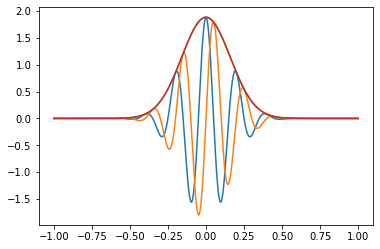

In [9]:
# plot wavelets
f_min = 3
f_max = 180
f_num = 1
morlet_reps = 5
wp = Wavelet(f_min,
             f_max,
             f_num,
             morlet_reps=morlet_reps,
             tmin=-3 / f_min, 
             tmax=3 / f_min)
sample_rate = 1000
freq = 5
t = np.linspace(-1, 1, 2 * sample_rate + 1)

wavelet = wp.Morlet(t, morlet_reps, f=freq)
sigma = wp.get_morlet_width(f=freq)
envelope = wp.get_morlet_envelope(t, sigma)
_ = plt.plot(t, wavelet.real)
_ = plt.plot(t, wavelet.imag)
_ = plt.plot(t, envelope)
_ = plt.plot(t, np.abs(wavelet))
print('Total wavelet power in time domain:',
      (np.abs(wavelet) ** 2).sum() / sample_rate)
print('Real wavelet power:',
      (wavelet.real ** 2).sum() / sample_rate)
print('Imaginary wavelet power:',
      (wavelet.imag ** 2).sum() / sample_rate)


Total wavelet power in time domain: 1.0000000000000004
Real wavelet power: 0.5000000000069441
Imaginary wavelet power: 0.49999999999305617


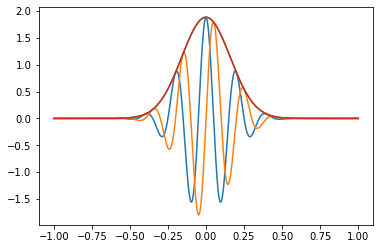

In [8]:
# plot wavelets with higher sample rate (should overlap with lower sample rate and be normalized to have same power)
f_min = 3
f_max = 180
f_num = 1
morlet_reps = 5
wp = Wavelet(f_min,
             f_max,
             f_num,
             morlet_reps=morlet_reps,
             tmin=-3 / f_min, 
             tmax=3 / f_min)
sample_rate = 2000
freq = 5
t = np.linspace(-1, 1, 2 * sample_rate + 1)

wavelet = wp.Morlet(t, morlet_reps, f=freq)
sigma = wp.get_morlet_width(f=freq)
envelope = wp.get_morlet_envelope(t, sigma)
_ = plt.plot(t, wavelet.real)
_ = plt.plot(t, wavelet.imag)
_ = plt.plot(t, envelope)
_ = plt.plot(t, np.abs(wavelet))
print('Total wavelet power in time domain:',
      (np.abs(wavelet) ** 2).sum() / sample_rate)
print('Real wavelet power:',
      (wavelet.real ** 2).sum() / sample_rate)
print('Imaginary wavelet power:',
      (wavelet.imag ** 2).sum() / sample_rate)


Total wavelet power in time domain after downsampling: 1.0000000000000004
Real wavelet power after downsampling: 0.5000000000069437
Imaginary wavelet power after downsampling: 0.49999999999305644


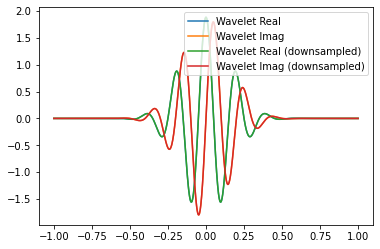

In [10]:
# subsample wavelets (should have same power)
t_downsampled = t[::2]
wavelet_downsampled = wavelet[::2]
sample_rate_downsampled = sample_rate * 0.5

_ = plt.plot(t, wavelet.real, label='Wavelet Real')
_ = plt.plot(t, wavelet.imag, label='Wavelet Imag')
_ = plt.plot(t_downsampled, wavelet_downsampled.real, label='Wavelet Real (downsampled)')
_ = plt.plot(t_downsampled, wavelet_downsampled.imag, label='Wavelet Imag (downsampled)')
_ = plt.legend()
print('Total wavelet power in time domain after downsampling:',
      (np.abs(wavelet_downsampled) ** 2).sum() / sample_rate_downsampled)
print('Real wavelet power after downsampling:',
      (wavelet_downsampled.real ** 2).sum() / sample_rate_downsampled)
print('Imaginary wavelet power after downsampling:',
      (wavelet_downsampled.imag ** 2).sum() / sample_rate_downsampled)



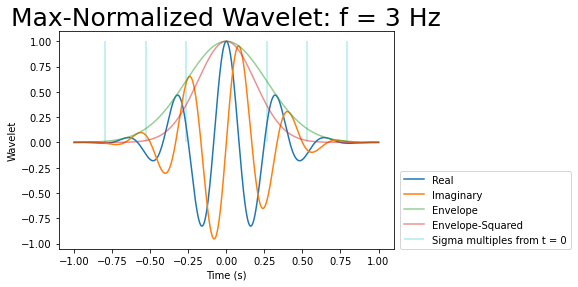

<Figure size 432x288 with 0 Axes>

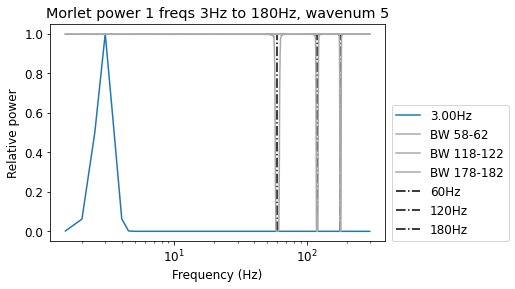

In [2]:
# plot wavelets
f_min = 3
f_max = 180
f_num = 1
morlet_reps = 5
wp = Wavelet(f_min,
             f_max,
             f_num,
             morlet_reps=morlet_reps,
             tmin=-3 / f_min, 
             tmax=3 / f_min)
wp.PlotF(f_min, plot_wavelet=True)
plt.figure()
wp.MakePlot()


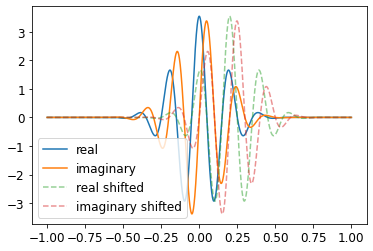

In [3]:
# plot offset wavelets
f_min = 3
f_max = 180
f_num = 1
morlet_reps = 5
wp = Wavelet(f_min,
             f_max,
             f_num,
             morlet_reps=morlet_reps,
             tmin=-3 / f_min, 
             tmax=3 / f_min)


theta_frequency = 5  # Hz
morlet = wp.Morlet(wp.tvals, wp.morlet_reps, theta_frequency)
phase_offset = 2*np.pi

offset = get_time_offset(phase_offset, theta_frequency)
morlet_shifted = wp.Morlet(wp.tvals - offset, wp.morlet_reps, theta_frequency)
_ = plt.plot(wp.tvals, morlet.real, label='real')
_ = plt.plot(wp.tvals, morlet.imag, label='imaginary')
_ = plt.plot(wp.tvals, morlet_shifted.real, label='real shifted', alpha=0.5, linestyle='--')
_ = plt.plot(wp.tvals, morlet_shifted.imag, label='imaginary shifted', alpha=0.5, linestyle='--')
_ = plt.legend()



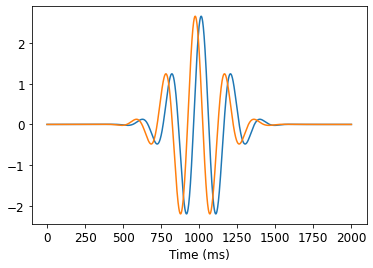

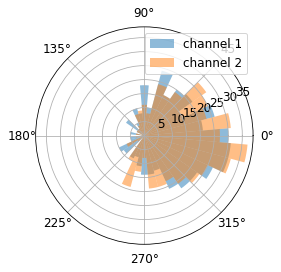

In [367]:
# sample phases from wrapped normal distribution and generate wavelets with phsae offsets

population_ppc = 0.2
samples = 500
frequency = 5  # Hz

sigma = ppc_to_wrapped_normal_sigma(population_ppc)
mean = np.array([0, 0])
cov = np.eye(2) * sigma ** 2
# cov = np.array([[sigma**2, sigma**2 / 2],
#                 [sigma**2 / 2, sigma**2]])
phases = sample_phases(mean=mean, cov=cov, samples=samples)

# samples x channels x time
wavelets = generate_event_wavelets(phases, duration_s=2, frequency=frequency)
_ = plt.plot(wavelets[0, 0])
_ = plt.plot(wavelets[0, 1])
_ = plt.xlabel('Time (ms)')

plt.figure()
polar_histogram(phases[:, 0], bins_number=36, area_proportional=False, label='channel 1')
polar_histogram(phases[:, 1], bins_number=36, area_proportional=False, label='channel 2')


## Simulate PPC Estimates

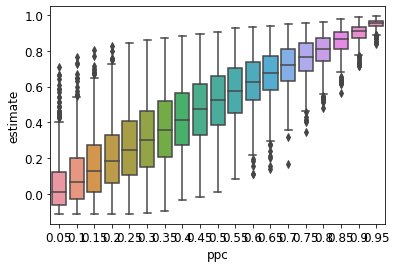

In [22]:
from cstat import ppc
import seaborn as sns

population_ppcs = np.linspace(0.05, 0.95, 19)
population_plvs = np.sqrt(population_ppcs)

n_simulations = 750
n_samples = 10

simulated_plvs = list()
estimated_ppcs = list()

for plv in population_plvs:
    for sim in range(n_simulations):
        kappa = plv_to_kappa(plv)
        phases = vonmises.rvs(kappa=kappa, loc=0, size=n_samples, random_state=sim)
        ppc_value = ppc(phases)
        simulated_plvs.append(plv)
        estimated_ppcs.append(ppc_value)

results = pd.DataFrame({'plv': simulated_plvs,
                        'estimate': estimated_ppcs})
results['ppc'] = np.round(results.plv ** 2, 2)
_ = sns.boxplot(data=results, x='ppc', y='estimate')

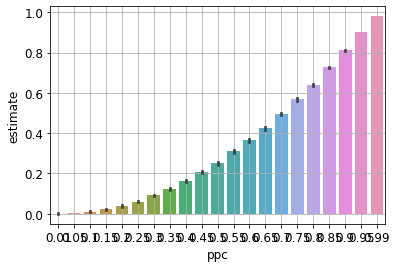

In [7]:
# PPC of phase differences
from cstat import ppc
import seaborn as sns

population_ppcs = np.concatenate([[0.01], np.linspace(0.05, 0.95, 19), [0.99]])
population_plvs = np.sqrt(population_ppcs)

n_simulations = 250
n_samples = 100

simulated_plvs = list()
estimated_ppcs = list()

for plv in population_plvs:
    for sim in range(n_simulations):
        kappa = plv_to_kappa(plv)
        phases1 = vonmises.rvs(kappa=kappa, loc=0, size=n_samples, random_state=sim)
        phases2 = vonmises.rvs(kappa=kappa, loc=0, size=n_samples, random_state=sim + n_simulations * 100)
        phases = phases2 - phases1
        ppc_value = ppc(phases)
        simulated_plvs.append(plv)
        estimated_ppcs.append(ppc_value)

results = pd.DataFrame({'plv': simulated_plvs,
                        'estimate': estimated_ppcs})
results['ppc'] = np.round(results.plv ** 2, 2)
_ = sns.barplot(data=results, x='ppc', y='estimate')
_ = plt.grid('on')

### Simulate PPC point estimates for wrapped normal distribution
PPC appears to provide an unbiased estimate of the first moment. The wrapped multivariate normal distribution provides simple dependencies between circular random variables.

In [8]:
# if
# X ~ WrappedNormal(mu_x, sigma_X**2)
# Y ~ WrappedNormal(mu_Y, sigma_Y**2)
# then
# Z = (X - Y) mod 2*pi ~ WrappedNormal((mu_X - mu_Y) mod 2*pi, sigma_X**2 + sigma_Y**2)
# for the wrapped normal distribution with linear parametrization

def diff_modulos(x, y, k):
    return ((x % k) - (y % k) ) % k

def diff_modulos2(x, y, k):
    return (x - y) % k

x = 1
y = 2
k = np.pi
print(diff_modulos(x, y, k))
print(diff_modulos2(x, y, k))


2.141592653589793
2.141592653589793


In [12]:
from cstat import ppc
import seaborn as sns

population_ppcs = np.sqrt(np.linspace(0.05, 0.95, 19))

n_simulations = 100
n_samples = 100

simulated_plvs = list()
estimated_ppcs = list()

random_state = 251
population_ppc = 0.5
n_samples = 25000
sigma = ppc_to_wrapped_normal_sigma(population_ppc)
np.random.seed(random_state)
phases_normal = sample_wrapped_multivariate_normal(mean=np.array([0]), cov=np.array([[sigma**2]]), size=n_samples)
# polar_histogram(phases_normal, bins_number=72, area_proportional=False, label='Wrapped Normal')

plv = np.sqrt(population_ppc)
kappa = plv_to_kappa(plv)
phases_von_mises = vonmises.rvs(kappa=kappa, loc=0, size=n_samples, random_state=random_state)
# polar_histogram(phases_von_mises, bins_number=72, area_proportional=False, label='von Mises')

print(f'Population PPC: {plv ** 2}. estimate for von Mises: {ppc(phases_von_mises)}. estimate for wrapped normal: {ppc(phases_normal)}')


Population PPC: 0.5000000000000001. estimate for von Mises: 0.49593066436563943. estimate for wrapped normal: [0.49709309]


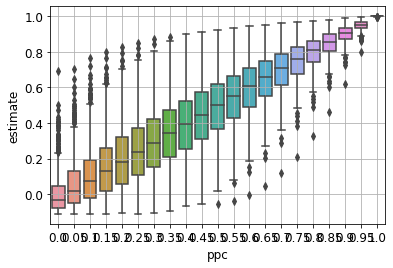

In [19]:
from cstat import plv_to_wrapped_normal_sigma
population_ppcs = np.concatenate([[0.001], np.linspace(0.05, 0.95, 19), [0.999]])
population_plvs = np.sqrt(population_ppcs)

n_simulations = 750
n_samples = 10

simulated_plvs = list()
estimated_ppcs = list()

for plv in population_plvs:
    for sim in range(n_simulations):
        sigma = plv_to_wrapped_normal_sigma(plv)
        np.random.seed(sim)
        phases = sample_wrapped_multivariate_normal(mean=np.array([0]), cov=[[sigma**2]], size=n_samples)[:, 0]
        ppc_value = ppc(phases)
        # if ppc_value < 0:
        #     print(ppc_value)
        #     print(phases.min(), phases.max())
        #     print()
        simulated_plvs.append(plv)
        estimated_ppcs.append(ppc_value)

results_normal = pd.DataFrame({'plv': simulated_plvs,
                               'estimate': estimated_ppcs})
results_normal['ppc'] = np.round(results_normal.plv ** 2, 2)
_ = sns.boxplot(data=results_normal, x='ppc', y='estimate')
_ = plt.grid('on')
# _ = plt.xticks(population_ppcs, rotation=45)


In [23]:
results.loc[:, ['distribution']] = 'von Mises'
results_normal.loc[:, ['distribution']] = 'wrapped normal'
results_distributions = pd.concat([results, results_normal], ignore_index=True)


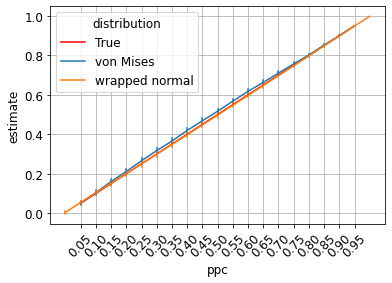

In [25]:
results['ppc'] = np.round(results_distributions.plv ** 2, 2)
_ = plt.plot(population_ppcs, population_ppcs, label='True', color='r')
_ = sns.lineplot(data=results_distributions, x='ppc', y='estimate', hue='distribution',
                 errorbar=('ci', 95), estimator='mean', err_style='bars')
plt.xticks(population_ppcs, rotation=45)
_ = plt.grid('on')


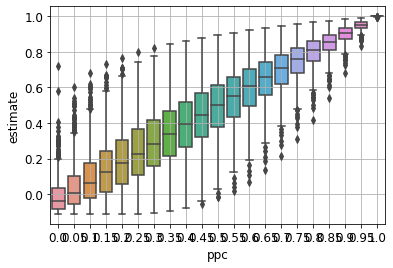

In [27]:
# plot for phase differences
population_ppcs = np.concatenate([[0.001], np.linspace(0.05, 0.95, 19), [0.999]])
population_plvs = np.sqrt(population_ppcs)

n_simulations = 750
n_samples = 10

simulated_plvs = list()
estimated_ppcs = list()

for plv in population_plvs:
    for sim in range(n_simulations):
        sigma = plv_to_wrapped_normal_sigma(plv)
        np.random.seed(sim)
        phases = sample_wrapped_multivariate_normal(mean=np.array([0, 0]),
                                                    cov=[[sigma**2, sigma**2 / 2], [sigma**2 / 2, sigma**2]], size=n_samples)
        phase_diffs = (phases[:, 0] - phases[:, 1]) % (2 * np.pi) - np.pi
        ppc_value = ppc(phase_diffs)
        # if ppc_value < 0:
        #     print(ppc_value)
        #     print(phases.min(), phases.max())
        #     print()
        simulated_plvs.append(plv)
        estimated_ppcs.append(ppc_value)

results_normal = pd.DataFrame({'plv': simulated_plvs,
                               'estimate': estimated_ppcs})
results_normal['ppc'] = np.round(results_normal.plv ** 2, 2)
_ = sns.boxplot(data=results_normal, x='ppc', y='estimate')
_ = plt.grid('on')
# _ = plt.xticks(population_ppcs, rotation=45)


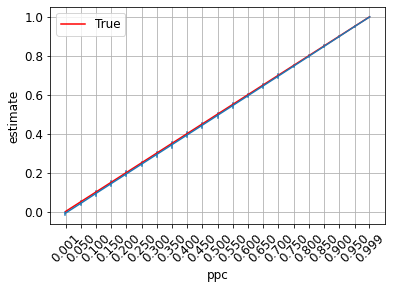

In [28]:
results_normal['ppc'] = np.round(results_normal.plv ** 2, 2)
_ = plt.plot(population_ppcs, population_ppcs, label='True', color='r')
_ = sns.lineplot(data=results_normal, x='ppc', y='estimate',
                 errorbar=('ci', 95), estimator='mean', err_style='bars')
plt.xticks(population_ppcs, rotation=45)
_ = plt.grid('on')


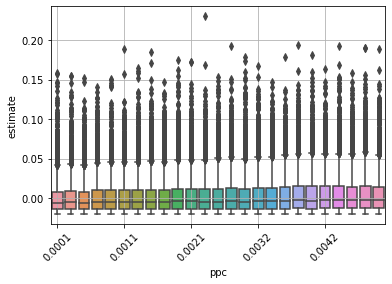

In [102]:
# plot for phase differences on same scale as observed in the RAM data set
from cstat import plv_to_wrapped_normal_sigma, ppc
population_ppcs = np.linspace(0.0001, 0.005, 25)
population_plvs = np.sqrt(population_ppcs)

n_simulations = 25000
n_samples = 50

simulated_plvs = list()
estimated_ppcs = list()

np.random.seed(0)
for plv in population_plvs:
    sigma = plv_to_wrapped_normal_sigma(plv)
    for sim in range(n_simulations):
        phases = sample_wrapped_multivariate_normal(mean=np.array([0, 0]),
                                                    cov=[[sigma**2, sigma**2 / 2], [sigma**2 / 2, sigma**2]], size=n_samples)
        phase_diffs = (phases[:, 0] - phases[:, 1]) % (2 * np.pi) - np.pi
        ppc_value = ppc(phase_diffs)
        # if ppc_value < 0:
        #     print(ppc_value)
        #     print(phases.min(), phases.max())
        #     print()
        simulated_plvs.append(plv)
        estimated_ppcs.append(ppc_value)

results_normal = pd.DataFrame({'plv': simulated_plvs,
                               'estimate': estimated_ppcs})
results_normal['ppc'] = np.round(results_normal.plv ** 2, 4)
_ = sns.boxplot(data=results_normal, x='ppc', y='estimate')
_ = plt.grid('on')
n_ticks = 5
tick_size = len(population_ppcs) // n_ticks
_ = plt.xticks(np.arange(0, len(population_ppcs), tick_size),
               np.round(population_ppcs[::tick_size], 4), rotation=45)


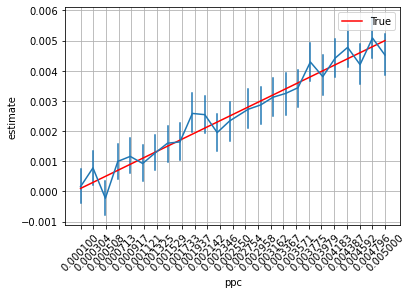

In [103]:
results_normal['ppc'] = np.round(results_normal.plv ** 2, 4)
_ = plt.plot(population_ppcs, population_ppcs, label='True', color='r')
_ = sns.lineplot(data=results_normal, x='ppc', y='estimate',
                 errorbar=('ci', 95), estimator='mean', err_style='bars')
plt.xticks(population_ppcs, rotation=45)
_ = plt.grid('on')


In [ ]:
# plot for phase differences on same scale as observed in the RAM data set for different sample sizes
from cstat import plv_to_wrapped_normal_sigma, ppc
population_ppcs = np.linspace(0.0001, 0.005, 25)
population_plvs = np.sqrt(population_ppcs)

n_simulations = 5000
sample_sizes = [10, 25, 50, 100, 200]
results = list()

np.random.seed(0)
for n_samples in sample_sizes:
    print(n_samples)
    simulated_plvs = list()
    estimated_ppcs = list()

    for plv in population_plvs:
        sigma = plv_to_wrapped_normal_sigma(plv)
        for sim in range(n_simulations):
            phases = sample_wrapped_multivariate_normal(mean=np.array([0, 0]),
                                                        cov=[[sigma**2, sigma**2 / 2], [sigma**2 / 2, sigma**2]], size=n_samples)
            phase_diffs = (phases[:, 0] - phases[:, 1]) % (2 * np.pi) - np.pi
            ppc_value = ppc(phase_diffs)
            # if ppc_value < 0:
            #     print(ppc_value)
            #     print(phases.min(), phases.max())
            #     print()
            simulated_plvs.append(plv)
            estimated_ppcs.append(ppc_value)

    results_sample_size = pd.DataFrame({'plv': simulated_plvs,
                                        'estimate': estimated_ppcs})
    results_sample_size['ppc'] = np.round(results_sample_size.plv ** 2, 4)
    results_sample_size['n_trials'] = n_samples
    results.append(results_sample_size)

results = pd.concat(results, ignore_index=True)

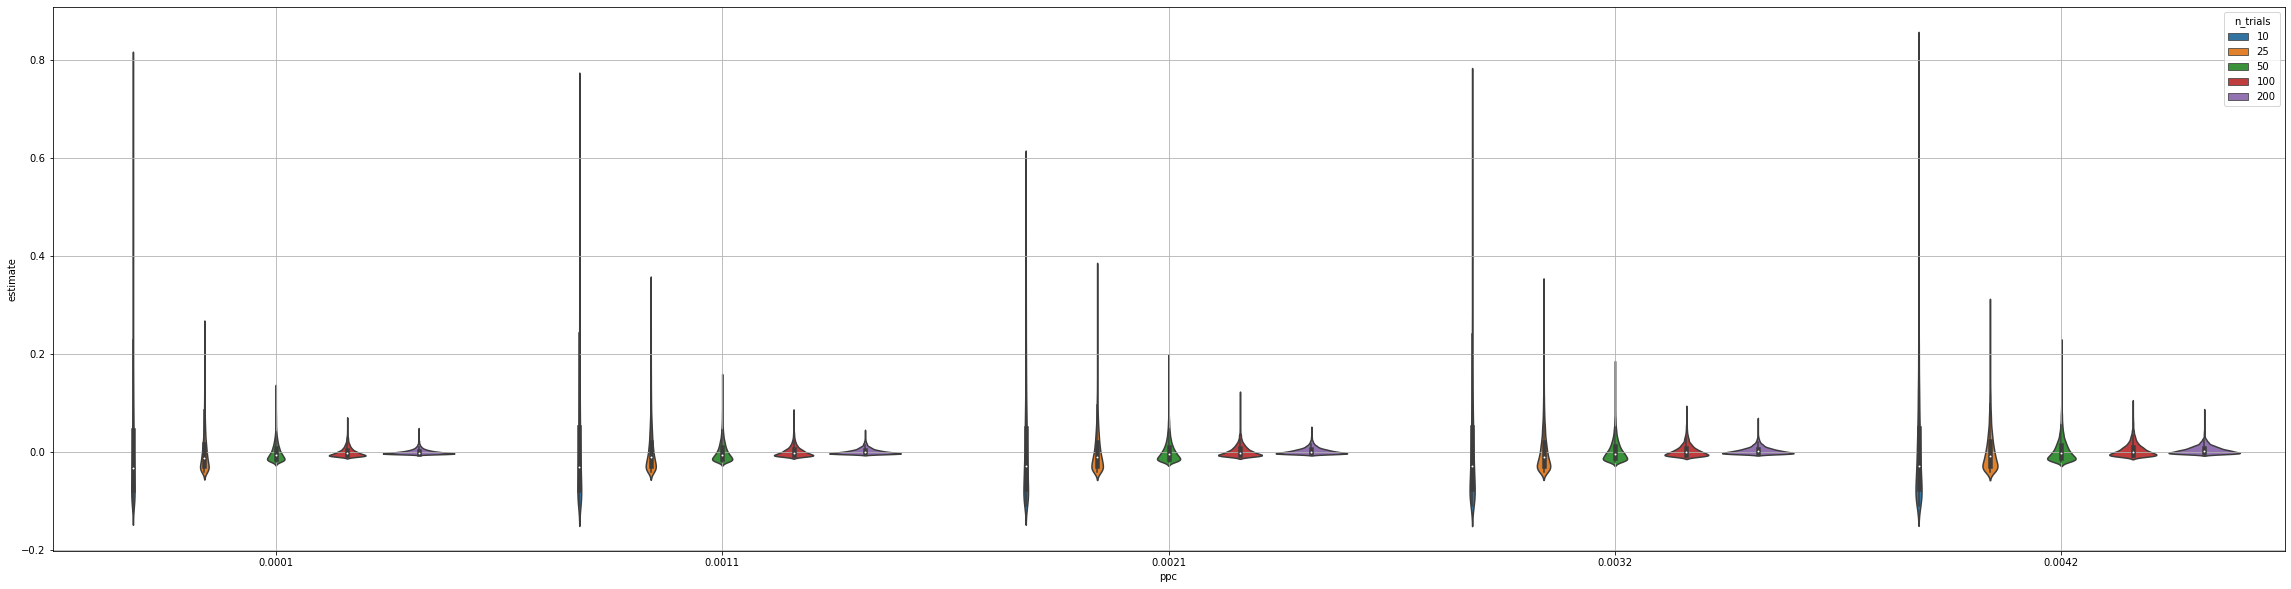

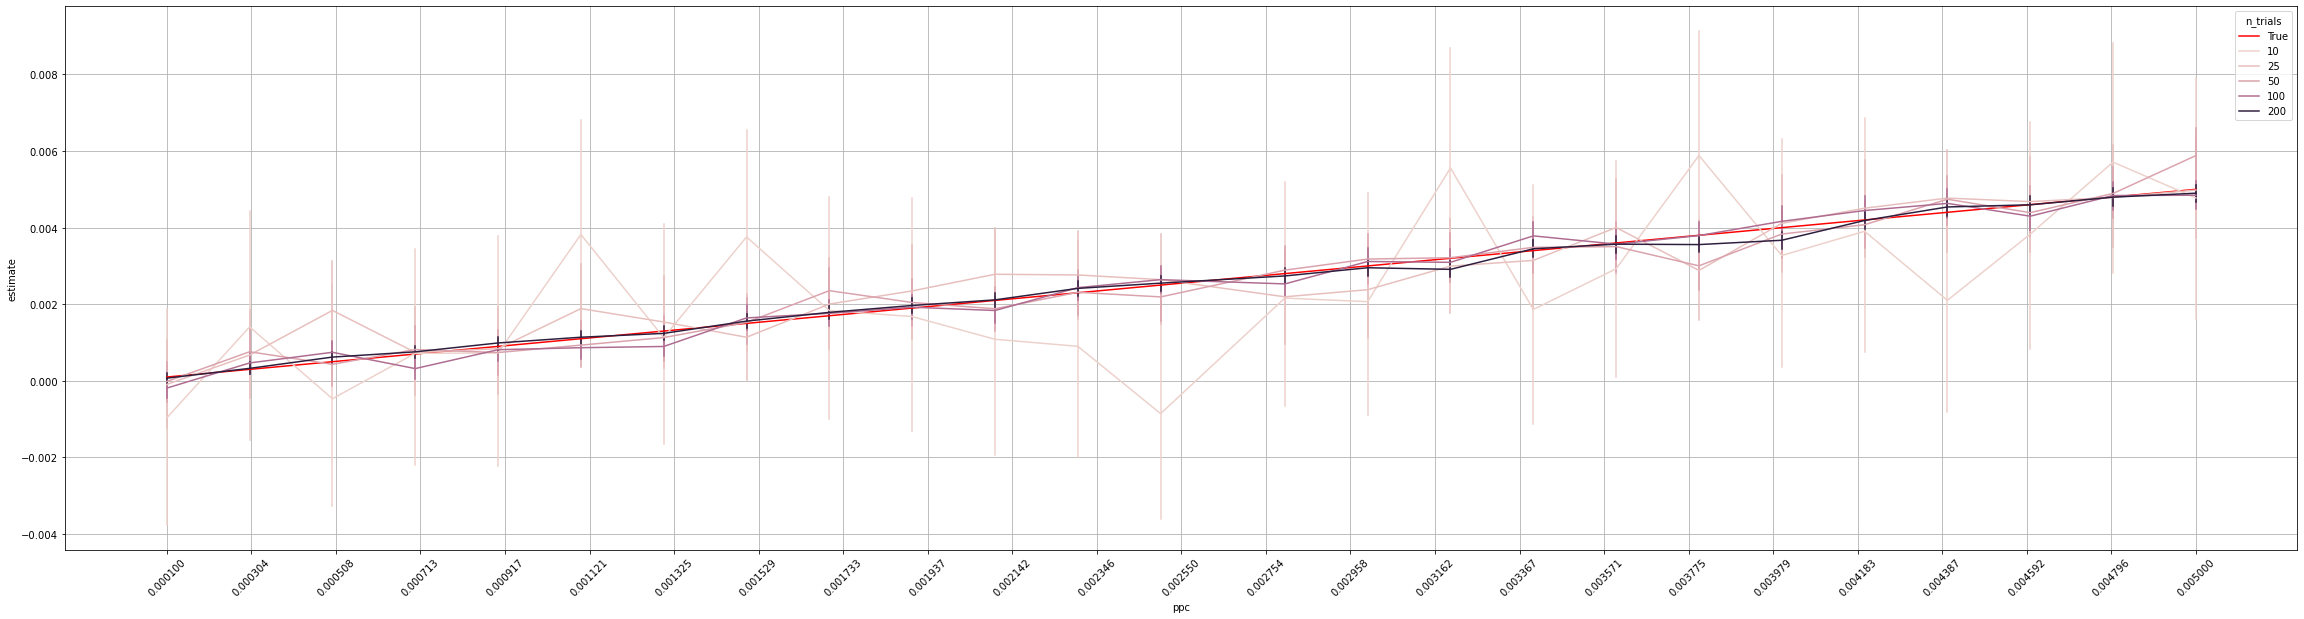

In [123]:
plt.figure(figsize=(40, 10))
plot_ppcs = np.round(population_ppcs[::5], 4)
_ = sns.violinplot(data=results.query('ppc in @plot_ppcs'), x='ppc', y='estimate', hue='n_trials')
_ = plt.grid('on')
# n_ticks = 5
# tick_size = len(population_ppcs) // n_ticks
# _ = plt.xticks(np.arange(0, len(population_ppcs), tick_size),
#                np.round(population_ppcs[::tick_size], 4), rotation=45)


plt.figure(figsize=(40, 10))
_ = plt.plot(population_ppcs, population_ppcs, label='True', color='r')
_ = sns.lineplot(data=results, x='ppc', y='estimate', hue='n_trials',
                 errorbar=('ci', 95), estimator='mean', err_style='bars')
plt.xticks(population_ppcs, rotation=45)
_ = plt.grid('on')


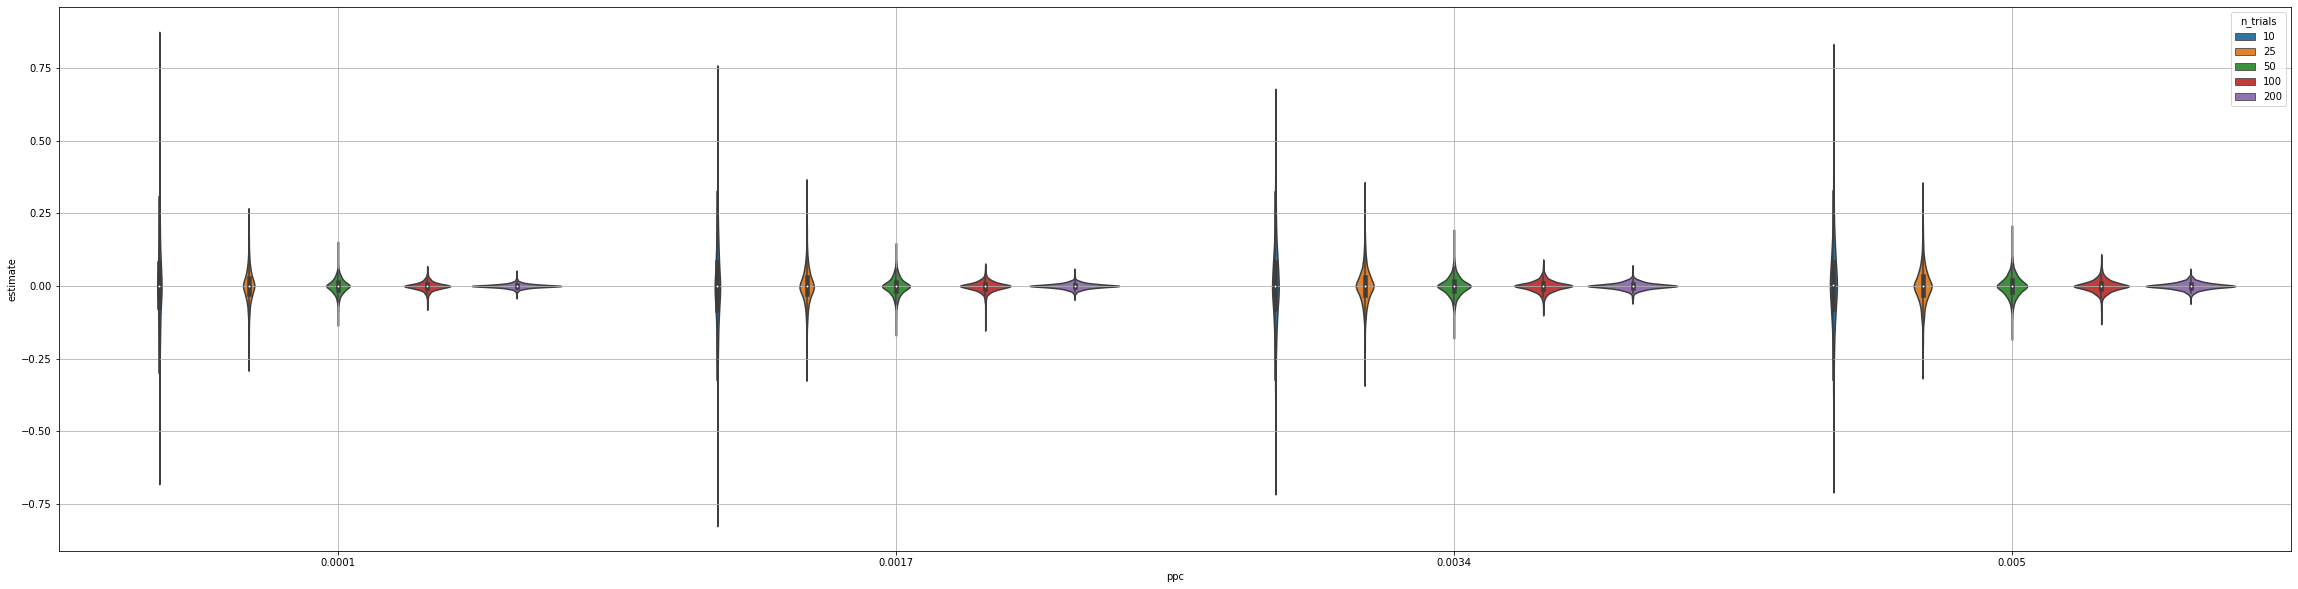

In [134]:
# plot PPC differences
plt.figure(figsize=(40, 10))
plot_ppcs = np.round(population_ppcs[::8], 4)
differences = results.query('ppc in @plot_ppcs')

def split_difference(df, column):
    assert isinstance(column, str)
    df1 = df.iloc[:len(df) // 2]
    df2 = df.iloc[-len(df) // 2:]
    df1.loc[:, [column]] = np.array(df1[column]) - np.array(df2[column])
    return df1

differences = differences.groupby(['ppc', 'n_trials']).apply(split_difference, column='estimate').reset_index(drop=True)
_ = sns.violinplot(data=differences, x='ppc', y='estimate', hue='n_trials')
_ = plt.grid('on')


In [129]:
differences.columns

Index(['plv', 'estimate', 'ppc', 'n_trials'], dtype='object')

In [140]:
from scipy.stats import kurtosis
group_cols = ['ppc', 'n_trials']

def kurtosis_column(df, column):
    kurt = kurtosis(df[column])
    df = df.iloc[0:1]
    df[column] = kurt
    return df
    
kurt_df = differences[group_cols + ['estimate']].groupby(group_cols).apply(kurtosis_column, column='estimate').reset_index(drop=True)
kurt_df#.sort_values('n_trials')

,ppc,n_trials,estimate
0,0.0001,10,2.185996
1,0.0001,25,2.403187
2,0.0001,50,2.310424
3,0.0001,100,2.212152
4,0.0001,200,3.315196
5,0.0017,10,1.925561
6,0.0017,25,3.103195
7,0.0017,50,2.301788
8,0.0017,100,5.740472
9,0.0017,200,2.315063


## Simulate EEG

In [2]:
from simulate_eeg import generate_pink_noise

sample_rate = 1000  # Hz
start_time_ms = -1000
duration_ms = 1000
buffer_ms = 1000
pinknoise_amplitude = 1
pinknoise_exponent = 2

duration_s = duration_ms / 1000
end_time_ms = start_time_ms + duration_ms
N_samples_per_epoch = duration_to_samples(duration_s, sample_rate)


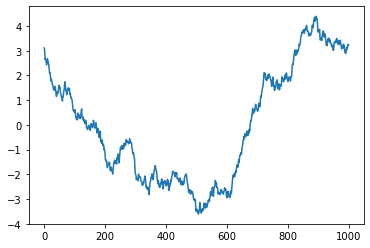

In [3]:
noise = generate_pink_noise(N_samples=N_samples_per_epoch,
                            pinknoise_amplitude=pinknoise_amplitude,
                            pinknoise_exponent=pinknoise_exponent)
_ = plt.plot(noise)


### Simulate EEG with wavelets

<xarray.DataArray (epoch: 5, frequency: 1, channel1: 2, channel2: 2)>
array([[[[1.        , 0.4943186 ],
         [0.4943186 , 1.        ]]],


       [[[1.        , 0.49430911],
         [0.49430911, 1.        ]]],


       [[[1.        , 0.49430912],
         [0.49430912, 1.        ]]],


       [[[1.        , 0.4943091 ],
         [0.4943091 , 1.        ]]],


       [[[1.        , 0.49431341],
         [0.49431341, 1.        ]]]])
Coordinates:
  * channel1   (channel1) <U3 'CH0' 'CH1'
  * channel2   (channel2) <U3 'CH0' 'CH1'
  * frequency  (frequency) int64 10
  * epoch      (epoch) int64 0 200 400 600 800

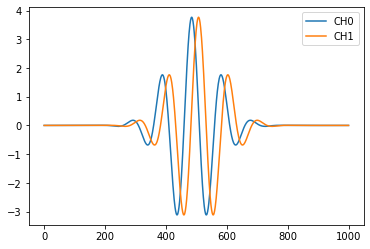

In [12]:
n_events = 200

population_ppc = 0.5
sigma = ppc_to_wrapped_normal_sigma(population_ppc)
mean = np.array([0, 0])

# cov = np.eye(2) * sigma ** 2
# 50% covariance reduces linear variance of phase differences by half vs. zero covariance,
# setting population PPC of phase differences to nominal value of population_ppc
cov = np.array([[sigma**2, sigma**2 / 2],
                [sigma**2 / 2, sigma**2]])

n_channels = len(mean)
wavelet_amplitude = 1
pinknoise_amplitude = 0
theta_frequency = 10
morlet_reps = 5

eeg = sample_eeg(n_events=n_events,
                 n_channels=n_channels,
                 phase_mean=mean,
                 phase_covariance=cov,
                 sample_rate_Hz=sample_rate,
                 start_time_ms=start_time_ms,
                 duration_ms=duration_ms,
                 wavelet_amplitude=wavelet_amplitude,
                 connectivity_frequency_Hz=theta_frequency,
                 morlet_reps=morlet_reps,
                 pinknoise_amplitude=pinknoise_amplitude,
                 pinknoise_exponent=pinknoise_exponent,
)

# plot one event
event_eeg = eeg[6]
for channel, channel_eeg in event_eeg.groupby('channel'):
    plt.plot(channel_eeg, label=channel)
_ = plt.legend()

from eeg_processing import get_phase, timebin_phase_timeseries
freqs = [theta_frequency]
phases = get_phase(eeg, freqs=freqs, width=5)
epoch_width_ms = 200
ppcs = compute_ppc_matrix_nonoverlapping(phases, phases.samplerate, epoch_width_ms=epoch_width_ms)
ppcs.transpose('epoch', 'frequency', 'channel1', 'channel2')


### Simulate noise distributions

Observed power: 8.93 +/- 10.04 (Mean +/- STD) (0.08201 SEM) across 15000 simulations
Expected power: 9
sample rate: 2000.0
Time diffs: [0.5]
Number of samples: 2001
signal.time.shape (2001,)
time range: -1000.0 0.0
sample time: -500.0


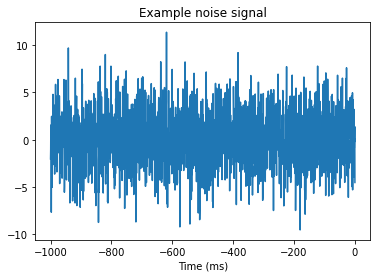

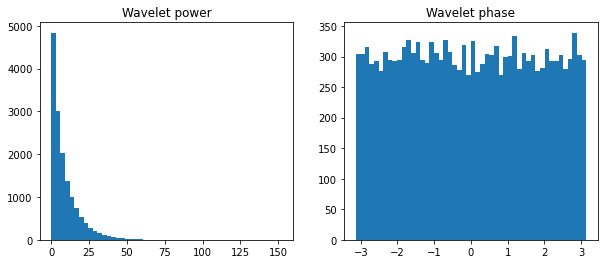

In [39]:
# simulate white noise

sample_rate = 2000  # Hz
start_time_ms = -1000
duration_ms = 1000
buffer_ms = 1000

duration_s = duration_ms / 1000
end_time_ms = start_time_ms + duration_ms

n_simulations = 15000
n_channels = 1
wavelet_amplitude = 0
pinknoise_amplitude = 3
pinknoise_exponent = 0
theta_frequency = 8
morlet_reps = 5

signal = sample_eeg(n_events=n_simulations,
                    n_channels=n_channels,
                    phase_mean=np.array([0]),
                    phase_covariance=np.array([[1]]),
                    sample_rate_Hz=sample_rate,
                    start_time_ms=start_time_ms,
                    duration_ms=duration_ms,
                    wavelet_amplitude=wavelet_amplitude,
                    connectivity_frequency_Hz=theta_frequency,
                    morlet_reps=morlet_reps,
                    pinknoise_amplitude=pinknoise_amplitude,
                    pinknoise_exponent=pinknoise_exponent,
)

plt.plot(signal.time, signal[0].squeeze())
_ = plt.title('Example noise signal')
_ = plt.xlabel('Time (ms)')

width = 5
freqs = [theta_frequency]
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=width, output=('power', 'phase'), complete=True, verbose=False)
signal_filtered = wavelet_filter.filter(timeseries=signal)
# this factor normalizes power of filtered signal to unity for white noise
# unclear why there's a factor of 2
N_samples = duration_to_samples(duration_s, sample_rate)


# phase = phase.transpose('event', 'channel', 'frequency', 'time')

sample_time = np.round(start_time_ms + duration_ms / 2)
signal_filtered = signal_filtered.sel(time=sample_time)
phases = signal_filtered[1].values.copy()

T_sample = 1/sample_rate
signal_filtered *= T_sample / 2
powers = signal_filtered[0]
mean_power = np.abs(powers).mean('event').item()
std_power = np.abs(powers).std('event', ddof=1).item()
sem_power = std_power / np.sqrt(n_simulations)
print(f'Observed power: {mean_power:0.4} +/- {std_power:0.4} (Mean +/- STD) ({sem_power:0.4} SEM) across {n_simulations} simulations')
expected_power = pinknoise_amplitude ** 2
print(f'Expected power: {expected_power}')

# debug PTSA Morlet wavelet issues with power levels scaling with signal duration:
print('sample rate:', signal.samplerate.values)
print('Time diffs:', np.unique(signal.time.diff('time')))
print('Number of samples:', N_samples)
print('signal.time.shape', signal.time.shape)
print('time range:', signal.time.min().item(), signal.time.max().item())
print('sample time:', sample_time)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
_ = plt.hist(powers.squeeze(), bins=50)
plt.title('Wavelet power')
plt.subplot(1, 2, 2)
_ = plt.hist(phases.squeeze(), bins=50)
_ = plt.title('Wavelet phase')


(2, 1, 2, 1, 1001)
Observed power: 0.9997 +/- 0.0 (Mean +/- STD) (0.0 SEM) across 2 simulations
Expected power: 0
sample rate: 1000.0
Time diffs: [1.]
Number of samples: 1001
signal.time.shape (1001,)
time range: -1000.0 0.0
sample time: -500.0
(2, 1, 1001)
1.0000000000138882


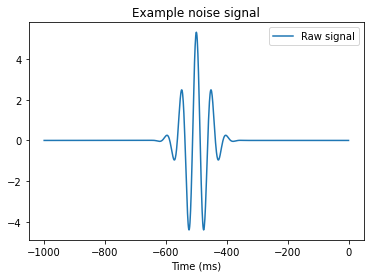

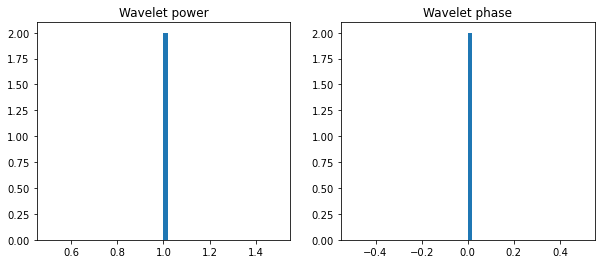

In [23]:
# simulate Morlet wavelets

sample_rate = 1000  # Hz
start_time_ms = -1000
duration_ms = 1000
buffer_ms = 1000

duration_s = duration_ms / 1000
end_time_ms = start_time_ms + duration_ms

n_simulations = 2
n_channels = 1
wavelet_amplitude = 1
pinknoise_amplitude = 0
pinknoise_exponent = 0
theta_frequency = 20
morlet_reps = 5

signal = sample_eeg(n_events=n_simulations,
                    n_channels=n_channels,
                    phase_mean=np.array([0]),
                    phase_covariance=np.array([[0]]),
                    sample_rate_Hz=sample_rate,
                    start_time_ms=start_time_ms,
                    duration_ms=duration_ms,
                    wavelet_amplitude=wavelet_amplitude,
                    connectivity_frequency_Hz=theta_frequency,
                    morlet_reps=morlet_reps,
                    pinknoise_amplitude=pinknoise_amplitude,
                    pinknoise_exponent=pinknoise_exponent,
)

plt.plot(signal.time, signal[0].squeeze(), label='Raw signal')
_ = plt.title('Example noise signal')
_ = plt.xlabel('Time (ms)')

width = morlet_reps
freqs = [theta_frequency]
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=width, output=('power', 'phase'), complete=True, verbose=False)
signal_filtered = wavelet_filter.filter(timeseries=signal)
# wavelet_filter_complex = MorletWaveletFilter(freqs=freqs, width=width, output=('complex'), complete=True, verbose=False)
# signal_filtered = wavelet_filter_complex.filter(timeseries=signal)
# angles = xr.DataArray(np.angle(signal_filtered),
#              dims=signal_filtered.dims,
#              coords=signal_filtered.coords)
# signal_filtered = xr.concat([np.abs(signal_filtered) ** 2, angles], dim='output')
print(signal_filtered.shape)
N_samples = duration_to_samples(duration_s, sample_rate)

T_sample = 1/sample_rate
# signal_filtered *= T_sample / 2
signal_filtered *= T_sample ** 2

# plt.plot(signal_filtered[0, 0, 0].squeeze(), label='Filtered signal')
plt.legend()


sample_time = np.round(start_time_ms + duration_ms / 2)
signal_filtered = signal_filtered.sel(time=sample_time)
powers = signal_filtered[0]
mean_power = np.abs(powers).mean('event').item()
std_power = np.abs(powers).std('event', ddof=1).item()
sem_power = std_power / np.sqrt(n_simulations)
print(f'Observed power: {mean_power:0.4} +/- {std_power:0.4} (Mean +/- STD) ({sem_power:0.4} SEM) across {n_simulations} simulations')
expected_power = pinknoise_amplitude ** 2
print(f'Expected power: {expected_power}')

# debug PTSA Morlet wavelet issues with power levels scaling with signal duration:
print('sample rate:', signal.samplerate.values)
print('Time diffs:', np.unique(signal.time.diff('time')))
print('Number of samples:', N_samples)
print('signal.time.shape', signal.time.shape)
print('time range:', signal.time.min().item(), signal.time.max().item())
print('sample time:', sample_time)
print(signal.shape)
print((signal[0] ** 2).sum().item() / sample_rate)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
_ = plt.hist(signal_filtered[0].squeeze(), bins=50)
plt.title('Wavelet power')
plt.subplot(1, 2, 2)
_ = plt.hist(signal_filtered[1].squeeze(), bins=50)
_ = plt.title('Wavelet phase')


In [132]:
# sanity check with Parseval's theorem
# print((signal.values ** 2).mean((0, 1)).sum() / N_samples)

# fft_signal = np.fft.fft(signal, axis=-1)
# (np.abs(fft_signal)**2).mean((0, 1)).sum() / N_samples ** 2

In [71]:
from cmldask.CMLDask import new_dask_client_slurm


(2, 1, 2, 1, 1001)
Observed power: 0.9792 +/- 0.06847 (Mean +/- STD) (0.04842 SEM) across 2 simulations
Expected power: 1
sample rate: 1000.0
Time diffs: [1.]
Number of samples: 1001
signal.time.shape (1001,)
time range: -1000.0 0.0
sample time: -500.0
(2, 1, 1001)
2.0932266918809037


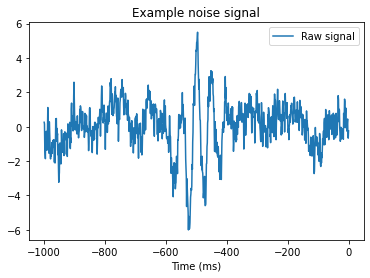

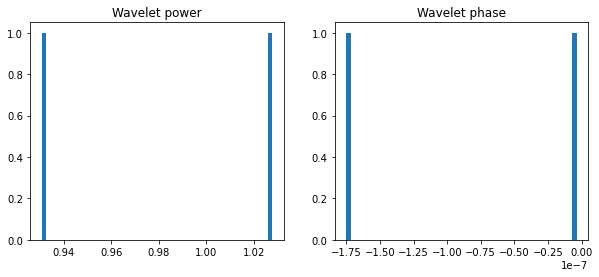

In [82]:
# simulate oscillations against pink noise background spectra

sample_rate = 1000  # Hz
start_time_ms = -1000
duration_ms = 1000
buffer_ms = 1000

duration_s = duration_ms / 1000
end_time_ms = start_time_ms + duration_ms

n_simulations = 2
n_channels = 1
wavelet_amplitude = 1
pinknoise_amplitude = 1
pinknoise_exponent = 1
theta_frequency = 20
morlet_reps = 7

signal = sample_eeg(n_events=n_simulations,
                    n_channels=n_channels,
                    phase_mean=np.array([0]),
                    phase_covariance=np.array([[0]]),
                    sample_rate_Hz=sample_rate,
                    start_time_ms=start_time_ms,
                    duration_ms=duration_ms,
                    wavelet_amplitude=wavelet_amplitude,
                    connectivity_frequency_Hz=theta_frequency,
                    morlet_reps=morlet_reps,
                    pinknoise_amplitude=pinknoise_amplitude,
                    pinknoise_exponent=pinknoise_exponent,
)

plt.plot(signal.time, signal[0].squeeze(), label='Raw signal')
_ = plt.title('Example noise signal')
_ = plt.xlabel('Time (ms)')

width = morlet_reps
freqs = [theta_frequency]
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=width, output=('power', 'phase'), complete=True, verbose=False)
signal_filtered = wavelet_filter.filter(timeseries=signal)
# wavelet_filter_complex = MorletWaveletFilter(freqs=freqs, width=width, output=('complex'), complete=True, verbose=False)
# signal_filtered = wavelet_filter_complex.filter(timeseries=signal)
# angles = xr.DataArray(np.angle(signal_filtered),
#              dims=signal_filtered.dims,
#              coords=signal_filtered.coords)
# signal_filtered = xr.concat([np.abs(signal_filtered) ** 2, angles], dim='output')
# print(signal_filtered.shape)
N_samples = duration_to_samples(duration_s, sample_rate)

T_sample = 1/sample_rate
# signal_filtered *= T_sample / 2
signal_filtered *= T_sample ** 2

# plt.plot(signal_filtered[0, 0, 0].squeeze(), label='Filtered signal')
plt.legend()


sample_time = np.round(start_time_ms + duration_ms / 2)
signal_filtered = signal_filtered.sel(time=sample_time)
powers = signal_filtered[0]
mean_power = np.abs(powers).mean('event').item()
std_power = np.abs(powers).std('event', ddof=1).item()
sem_power = std_power / np.sqrt(n_simulations)
print(f'Observed power: {mean_power:0.4} +/- {std_power:0.4} (Mean +/- STD) ({sem_power:0.4} SEM) across {n_simulations} simulations')
expected_power = pinknoise_amplitude ** 2
print(f'Expected power: {expected_power}')

# debug PTSA Morlet wavelet issues with power levels scaling with signal duration:
print('sample rate:', signal.samplerate.values)
print('Time diffs:', np.unique(signal.time.diff('time')))
print('Number of samples:', N_samples)
print('signal.time.shape', signal.time.shape)
print('time range:', signal.time.min().item(), signal.time.max().item())
print('sample time:', sample_time)
print(signal.shape)
print((signal[0] ** 2).sum().item() / sample_rate)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
_ = plt.hist(signal_filtered[0].squeeze(), bins=50)
plt.title('Wavelet power')
plt.subplot(1, 2, 2)
_ = plt.hist(signal_filtered[1].squeeze(), bins=50)
_ = plt.title('Wavelet phase')


## Generate connectivity covariance matrix

In [4]:
n_regions = 80
n_region_combinations = n_regions ** 2
n_blocks = 10
n_epochs = 5

region_block_size = 8

mean_subject_delta_PPC = 0.001

connection_sparsity = 0.01

estimated_regionwise_delta_PPC = mean_subject_delta_PPC * n_region_combinations * connection_sparsity
print(f'Average PPC among {n_region_combinations} regional connections assuming {connection_sparsity} connection sparsity:', estimated_regionwise_delta_PPC)


Average PPC among 6400 regional connections assuming 0.01 connection sparsity: 0.064


Mean PPC: 0.16000000000000003


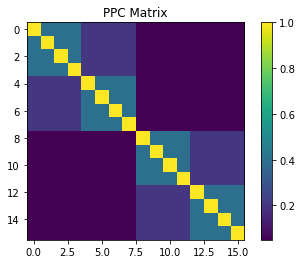

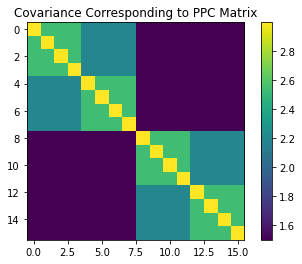

In [5]:
from cstat import wrapped_normal_sigma_to_ppc, ppc_to_wrapped_normal_sigma, sample_wrapped_multivariate_normal
from matrix_operations import is_square, is_symmetric, is_positive_definite, strict_triu, upper_tri_values, off_diagonal_values
from simulate_eeg import ppc_matrix_to_wrapped_normal_covariance, get_block_diagonal_ppc_matrix


ppc_matrix = get_block_diagonal_ppc_matrix(n_channels=16,
                                           n_regions=4,
                                           n_region_groups=2,
                                           global_ppc=0.05,
                                           within_group_ppc=0.2,
                                           within_region_ppc=0.4,
                                           verbose=True)
connectivity_covar = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix)

theta_frequencies = list(np.arange(1, 11, 2))

plt.figure()
plt.imshow(connectivity_covar)
plt.colorbar()
_ = plt.title('Covariance Corresponding to PPC Matrix')


## Simulate Subject-level PPC

In [61]:
def simulate_subject_eeg_ppc(n_events=100,
                            n_channels=5,
                            wavelet_amplitude=1,
                            pinknoise_amplitude=1,
                            pinknoise_exponent=1,
                            theta_frequency=5,
                            morlet_reps=5,
                            connectivity_covar=None,
                            sample_rate=1000,  # Hz
                            start_time_ms=-1000,
                            duration_ms=1000,
                            buffer_ms=1000,
                            phase_estimate_frequencies=[5],
                            epoch_width_ms=200,
                            verbose=False,
                            ppc_matrix=None):
    if verbose:
        assert ppc_matrix is not None
    if wavelet_amplitude > 0:
        assert connectivity_covar is not None
    elif wavelet_amplitude < 0:
        raise ValueError
    
    duration_s = duration_ms / 1000
    end_time_ms = start_time_ms + duration_ms

    signal = sample_eeg(n_events=n_events,
                        n_channels=n_channels,
                        phase_mean=np.zeros(len(connectivity_covar)) if connectivity_covar is not None else None,
                        phase_covariance=connectivity_covar,
                        sample_rate_Hz=sample_rate,
                        start_time_ms=start_time_ms,
                        duration_ms=duration_ms,
                        wavelet_amplitude=wavelet_amplitude,
                        connectivity_frequency_Hz=theta_frequency,
                        morlet_reps=morlet_reps,
                        pinknoise_amplitude=pinknoise_amplitude,
                        pinknoise_exponent=pinknoise_exponent,
    )

    from eeg_processing import get_phase, timebin_phase_timeseries
    phases = get_phase(signal, freqs=phase_estimate_frequencies, width=5)
    estimated_ppcs = compute_ppc_matrix_nonoverlapping(phases, phases.samplerate, epoch_width_ms=epoch_width_ms)

    if verbose:
        n_examples = 5
        plt.figure(figsize=(25, 5))
        for example in range(n_examples):
            plt.subplot(1, 5, example + 1)
            plt.plot(signal.time, signal[example, 0].T, label='Raw signal')
            _ = plt.xlabel('Time (ms)')
        _ = plt.suptitle('Example event EEG observations')

        # compute expected and observed signal power for phase-locked and noise components
        wavelet_filter = MorletWaveletFilter(freqs=[theta_frequency],
                                             width=morlet_reps,
                                             output=('power', 'phase'),
                                             complete=True,
                                             verbose=False)
        signal_filtered = wavelet_filter.filter(timeseries=signal)
        phases_filtered = signal_filtered[1, 0, :, :].copy()
        
        # renormalize oscillatory power, which apparently has extra factor of T_sample on top of numerical integration constant
        N_samples = duration_to_samples(duration_s, sample_rate)
        T_sample = 1/sample_rate
        # signal_filtered *= T_sample / 2
        signal_filtered *= T_sample ** 2

        sample_time = np.round(start_time_ms + duration_ms / 2)
        signal_filtered = signal_filtered.sel(time=sample_time)
        phases_filtered = phases_filtered.sel(time=sample_time)
        powers = signal_filtered[0, 0, :, :]
        mean_power = np.abs(powers).mean('event').mean('channel').item()
        std_power = np.abs(powers).std('event', ddof=1).mean('channel').item()
        sem_power = std_power / np.sqrt(n_events)
        print(f'Observed total power: {mean_power:0.4} +/- {std_power:0.4} (Mean +/- STD) ({sem_power:0.4} SEM) across {n_events} simulations')
        expected_signal_power = wavelet_amplitude ** 2
        print(f'Expected signal power: {expected_signal_power}')
        expected_noise_power = pinknoise_amplitude ** 2
        print(f'Expected pink noise power: {expected_noise_power}')

        print('Average normalized power across channels and trials:',
              (signal ** 2).sum().item() / (sample_rate * n_channels * n_events))

        # plot filtered power and phase values at center of window
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        _ = plt.hist(signal_filtered[0].squeeze().values.ravel(), bins=50)
        plt.title('Wavelet power')
        plt.subplot(1, 2, 2)
        _ = plt.hist(phases_filtered.squeeze().values.ravel(), bins=50)
        _ = plt.title('Wavelet phase')

        # plot estimated and theoretical PPC matrices
        for frequency, estimated_ppcs_freq in estimated_ppcs.groupby('frequency'):
            plt.figure(figsize=(25, 5))
            for n_epoch, (epoch, estimated_ppcs_epoch) in enumerate(estimated_ppcs_freq.groupby('epoch')):
                plt.subplot(1, len(estimated_ppcs.epoch), n_epoch + 1)
                plt.imshow(estimated_ppcs_epoch, vmin=min(0, float(estimated_ppcs_epoch.min())), vmax=1)
                plt.colorbar()
                plt.title(f'Epoch: {epoch} ms)')
            plt.suptitle(f'Estimated PPC matrix for {frequency} Hz (Oscillatory freq: {theta_frequency} Hz)')

        plt.figure()
        plt.imshow(ppc_matrix, vmin=min(0, float(ppc_matrix.min())), vmax=1)
        plt.colorbar()
        _ = plt.title(f'Theoretical PPC Matrix at {theta_frequency} Hz')

        if not is_symmetric(estimated_ppcs.mean('epoch')):
            print('PPC estimates are not symmetric!')

        # plot errors in PPC estimates from theoretical values for all frequencies
        plt.figure()
        for freq, estimated_ppcs_freq in estimated_ppcs.groupby('frequency'):
            if freq == theta_frequency:
                freq_ppc_matrix = ppc_matrix
            else:
                freq_ppc_matrix = np.zeros_like(ppc_matrix)
            ppc_errors = upper_tri_values((estimated_ppcs_freq.mean('epoch') - freq_ppc_matrix).values,
                                          include_diagonal=False)
            plt.hist(ppc_errors, bins=50, label=f'{freq} Hz', alpha=0.3)
        plt.title('Errors in PPC Estimates across frequencies')
        plt.legend()
        
        if theta_frequency in estimated_ppcs.frequency:
            # just for oscillatory frequency
            plt.figure()
            oscillatory_estimated_ppcs = estimated_ppcs.sel(frequency=theta_frequency)
            ppc_errors = upper_tri_values((oscillatory_estimated_ppcs.mean('epoch') - ppc_matrix).values,
                                          include_diagonal=False)
            ppc_values = upper_tri_values(ppc_matrix, include_diagonal=False)
            unique_ppcs = np.unique(ppc_values)
            for ppc_val in unique_ppcs:
                mask = np.where(ppc_values == ppc_val)
                ppc_val_errors = ppc_errors[mask]
                plt.hist(ppc_val_errors, bins=50, label=f'PPC: {ppc_val}', alpha=1/len(unique_ppcs))
            plt.title(f'Errors in PPC Estimates at oscillatory frequency ({theta_frequency} Hz)')
            plt.legend()
        
    return signal, estimated_ppcs

# _ = simulate_subject_eeg_ppc(n_events=15,
#                             n_channels=n_channels,
#                             wavelet_amplitude=1,
#                             pinknoise_amplitude=0,
#                             pinknoise_exponent=2,
#                             theta_frequency=5,
#                             morlet_reps=5,
#                             connectivity_covar=connectivity_covar,
#                             sample_rate=1000,  # Hz
#                             start_time_ms=-1000,
#                             duration_ms=1000,
#                             buffer_ms=1000,
#                              phase_estimate_frequencies=theta_frequencies,
#                             verbose=True,
#                             ppc_matrix=ppc_matrix)


Observed total power: 0.9538 +/- 0.04895 (Mean +/- STD) (0.002189 SEM) across 500 simulations
Expected signal power: 1
Expected pink noise power: 0
Average normalized power across channels and trials: 0.9999660274344625


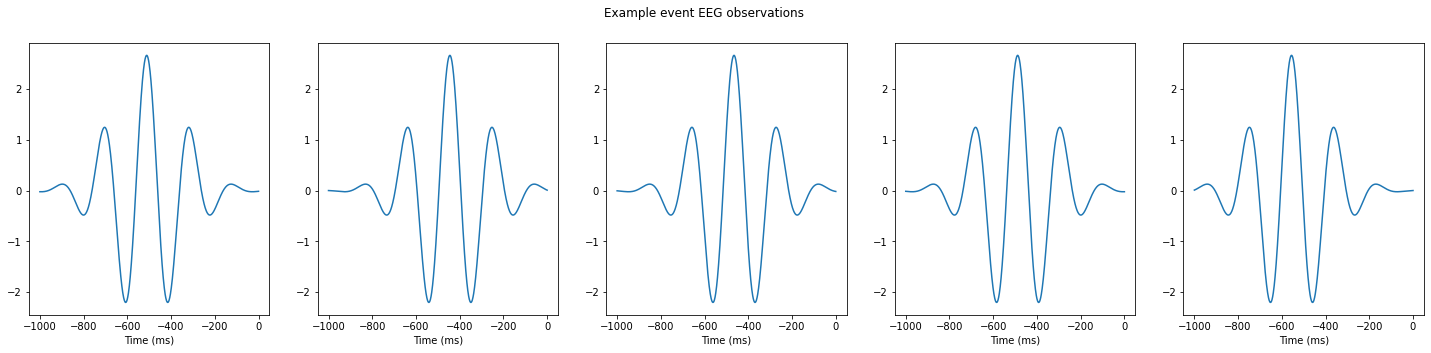

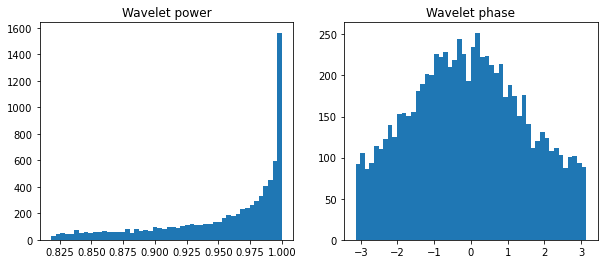

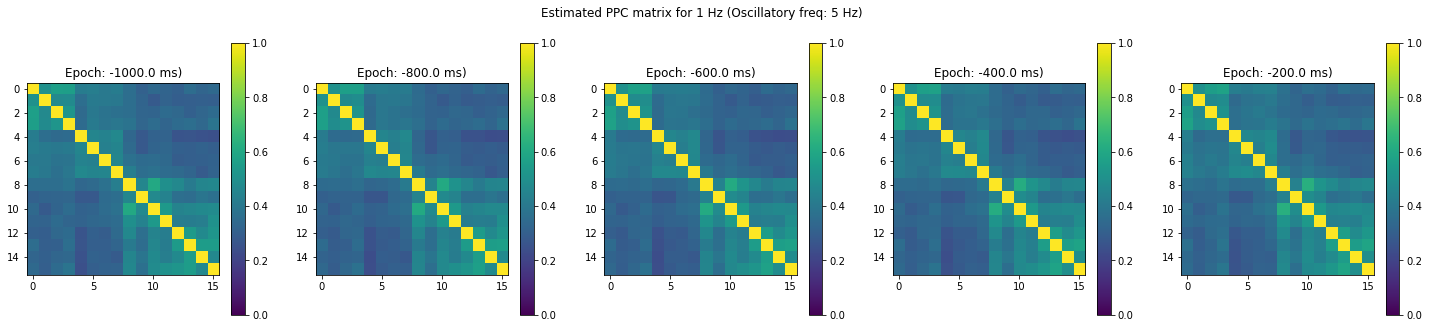

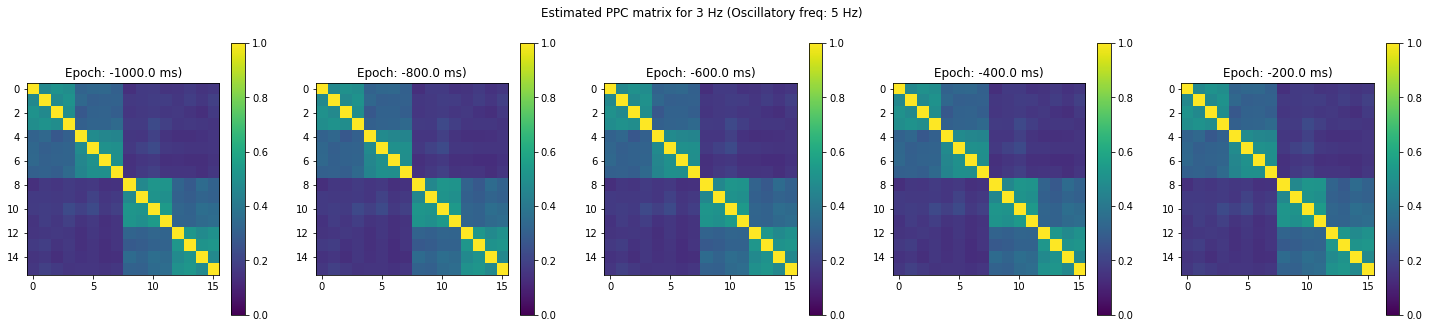

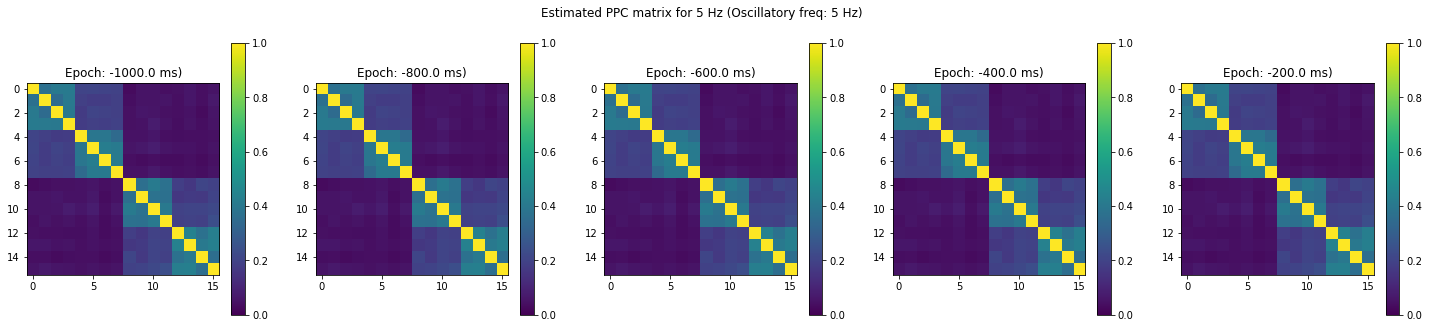

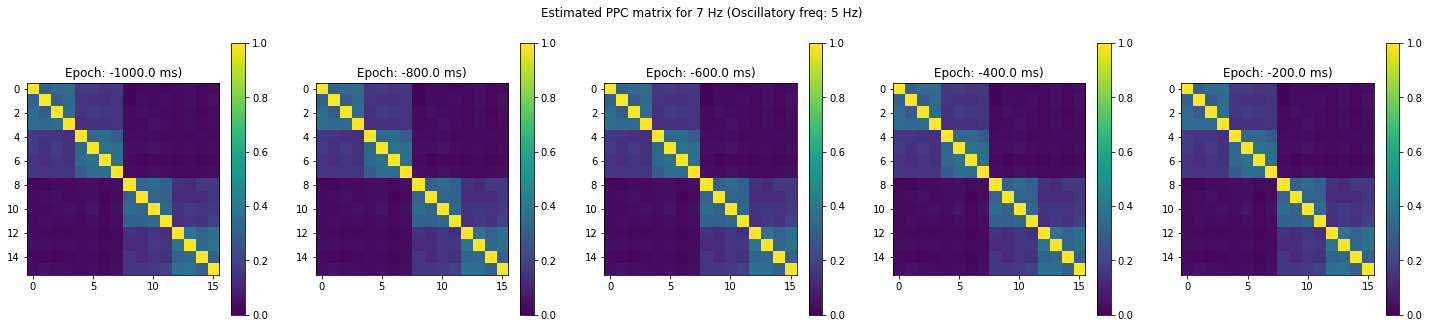

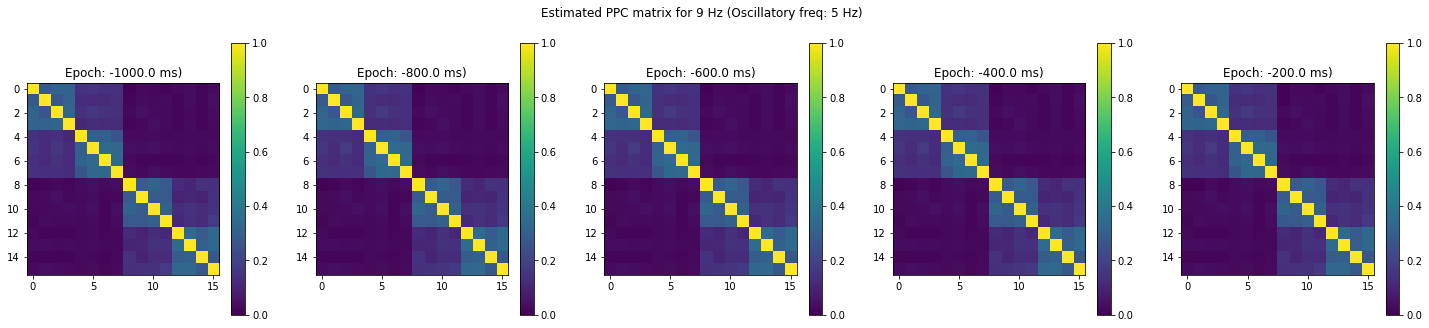

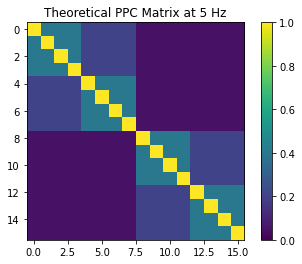

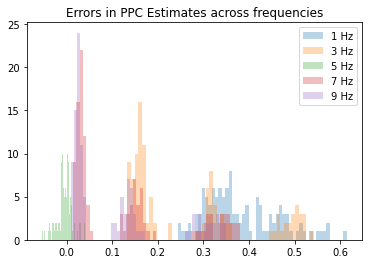

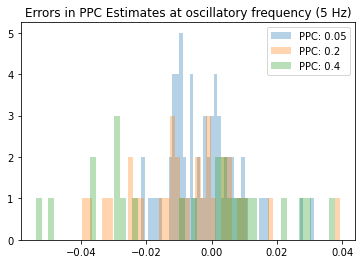

In [62]:
# simulate PPC estimates for oscillations alone

theta_frequency = 5
n_channels = 16

_ = simulate_subject_eeg_ppc(n_events=500,
                            n_channels=n_channels,
                            wavelet_amplitude=1,
                            pinknoise_amplitude=0,
                            pinknoise_exponent=2,
                            theta_frequency=theta_frequency,
                            morlet_reps=5,
                            connectivity_covar=connectivity_covar,
                            sample_rate=1000,  # Hz
                            start_time_ms=-1000,
                            duration_ms=1000,
                            buffer_ms=1000,
                             phase_estimate_frequencies=theta_frequencies,
                            verbose=True,
                            ppc_matrix=ppc_matrix)


Observed total power: 0.9815 +/- 0.2317 (Mean +/- STD) (0.01036 SEM) across 500 simulations
Expected signal power: 1
Expected pink noise power: 1
Average normalized power across channels and trials: 2.0117928722358545


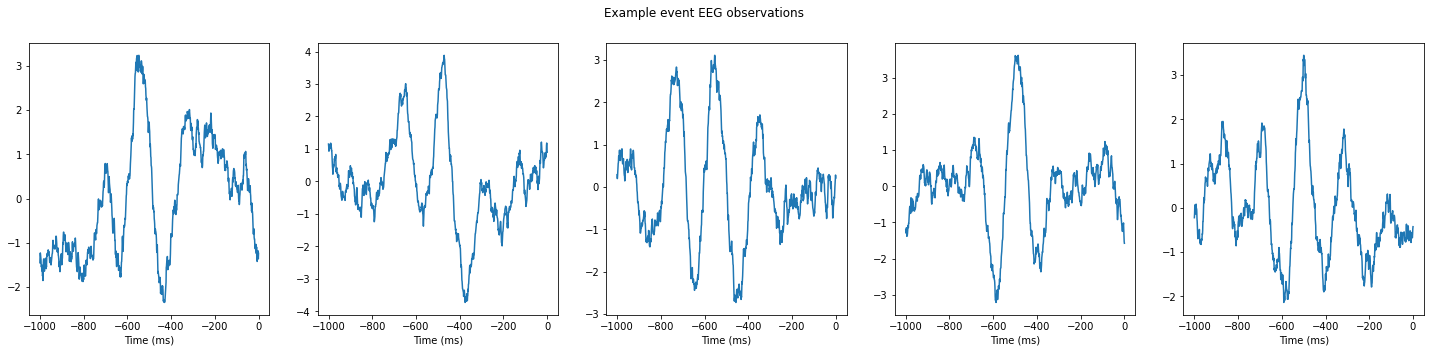

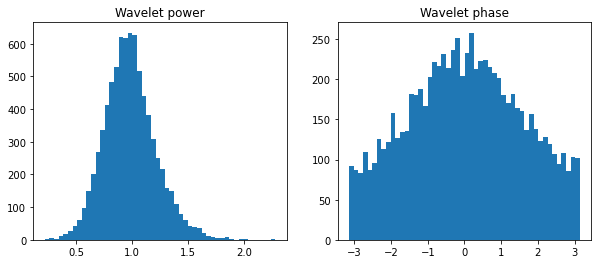

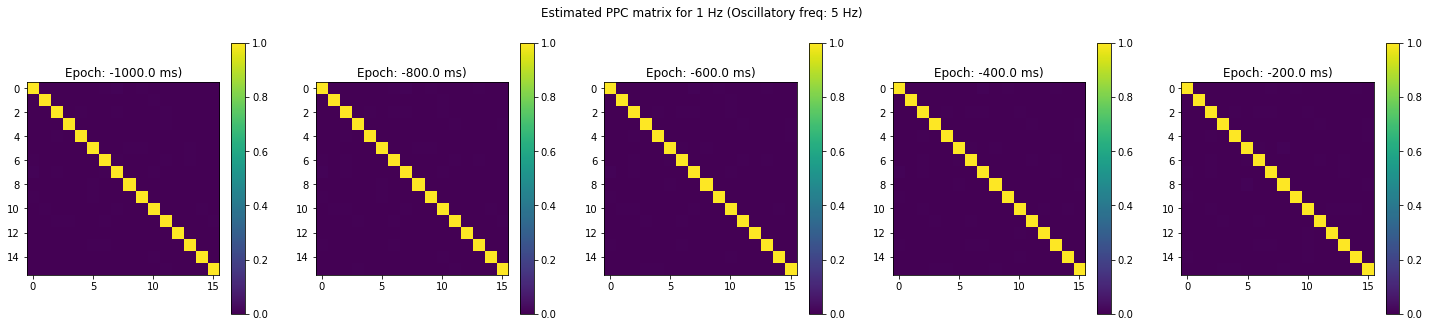

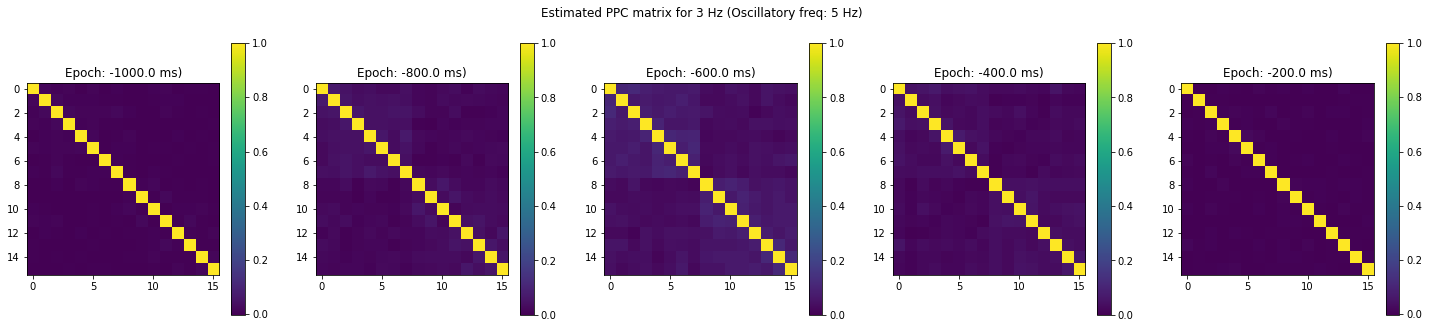

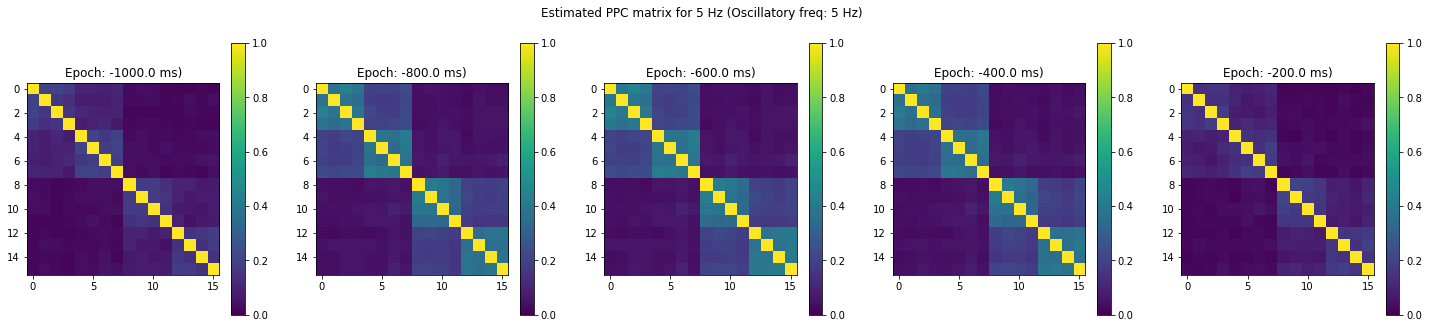

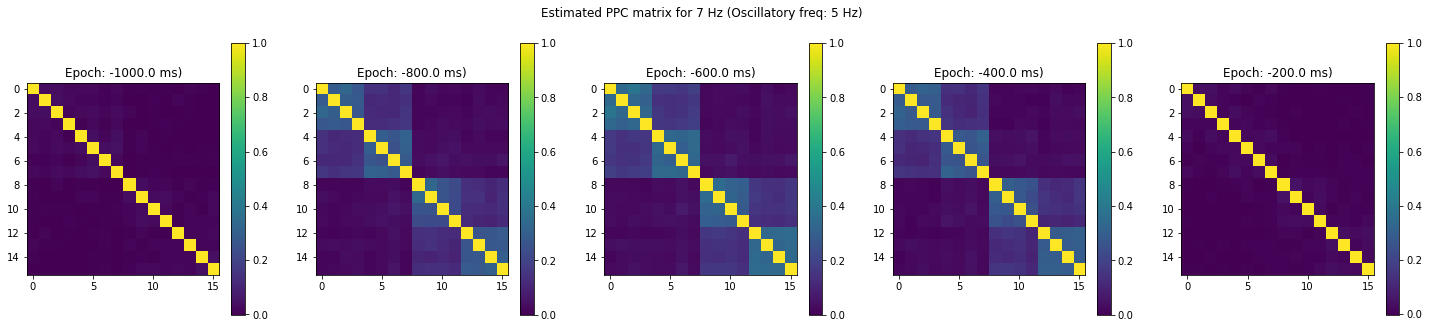

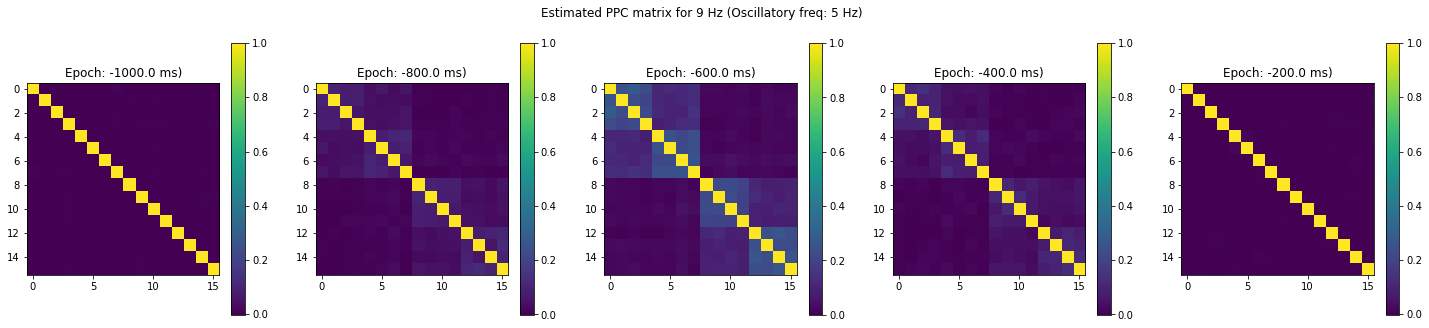

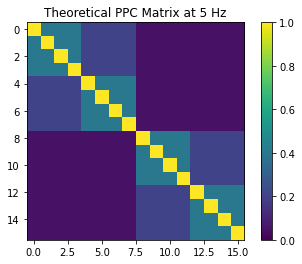

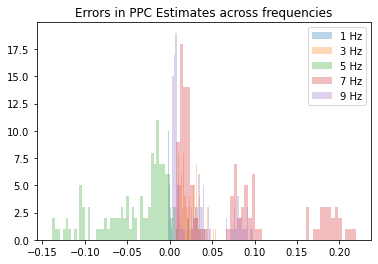

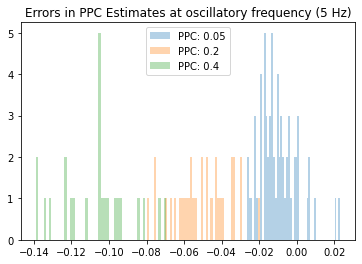

In [63]:
# incorporate noise in connectivity pattern

# noise injects uniform random phase noise into signal
# phase distribution of sums of random variables (e.g., complex normal distributed variables) quickly gets complicated. 
# See Luo et al. (2020) "Analysis on Functions and Characteristics of the Rician Phase Distribution"

# rather than try to derive the phase distribution for our additive noise model, I add a reasonable amount of noise and confirm that we can still estimate the PPC

# simulate EEG with desired connectivity pattern


theta_frequency = 5
n_channels = 16

_ = simulate_subject_eeg_ppc(n_events=500,
                            n_channels=n_channels,
                            wavelet_amplitude=1,
                            pinknoise_amplitude=1,
                            pinknoise_exponent=2,
                            theta_frequency=5,
                            morlet_reps=5,
                            connectivity_covar=connectivity_covar,
                            sample_rate=1000,  # Hz
                            start_time_ms=-1000,
                            duration_ms=1000,
                            buffer_ms=1000,
                             phase_estimate_frequencies=theta_frequencies,
                            verbose=True,
                            ppc_matrix=ppc_matrix)


Observed total power: 0.02657 +/- 0.03089 (Mean +/- STD) (0.001381 SEM) across 500 simulations
Expected signal power: 0
Expected pink noise power: 1
Average normalized power across channels and trials: 1.002596566058664


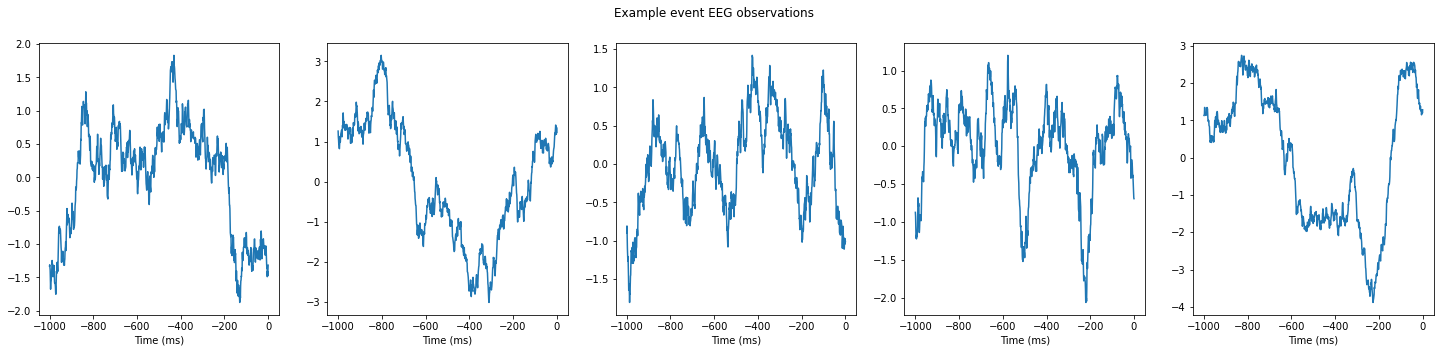

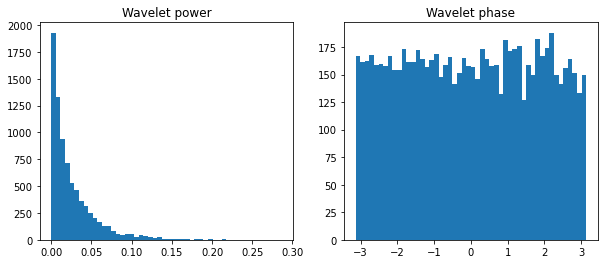

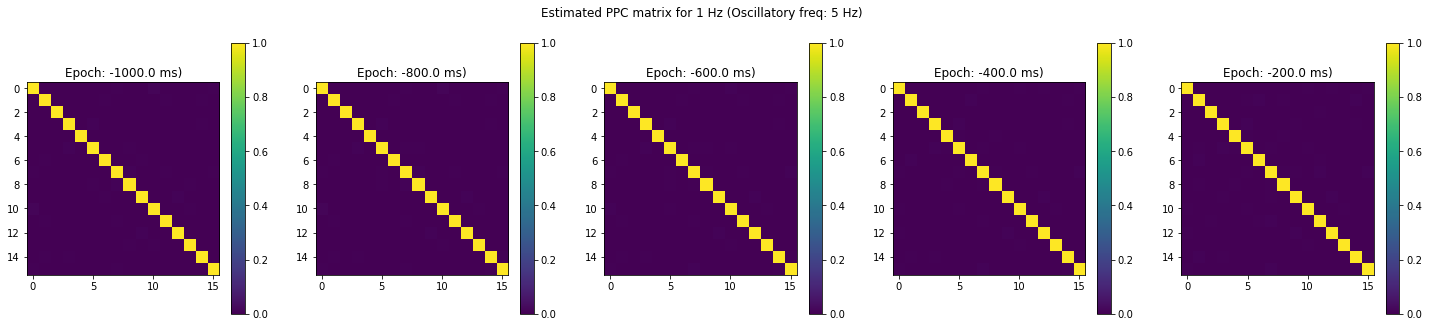

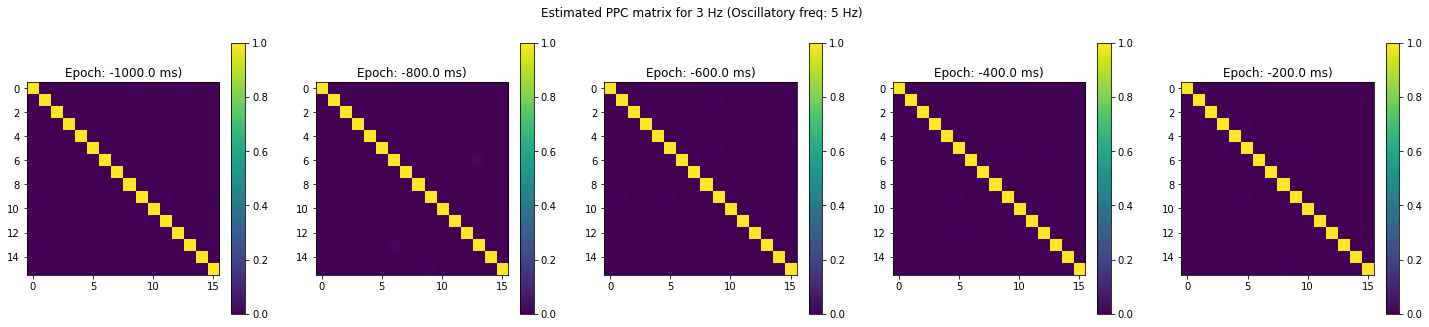

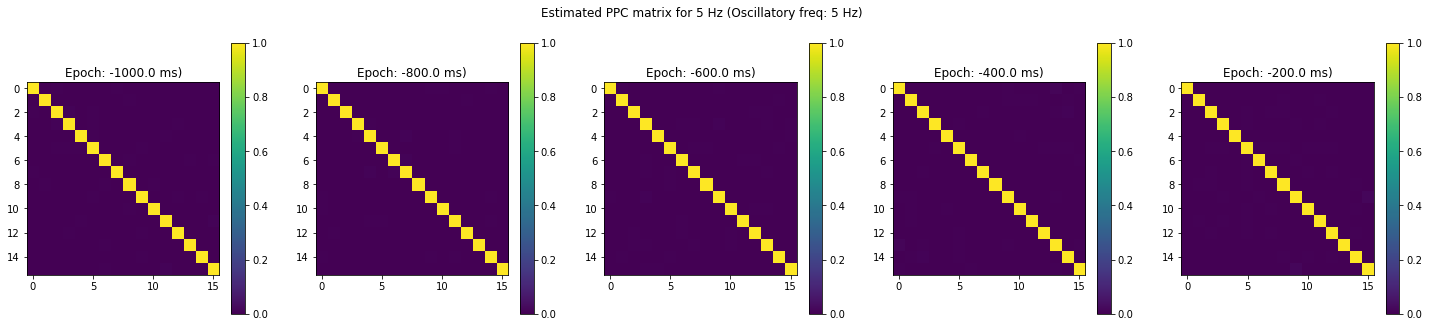

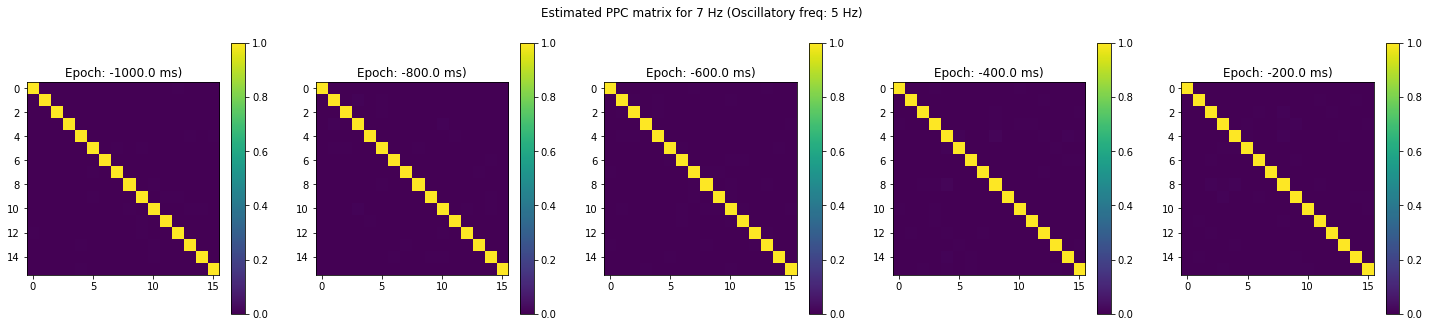

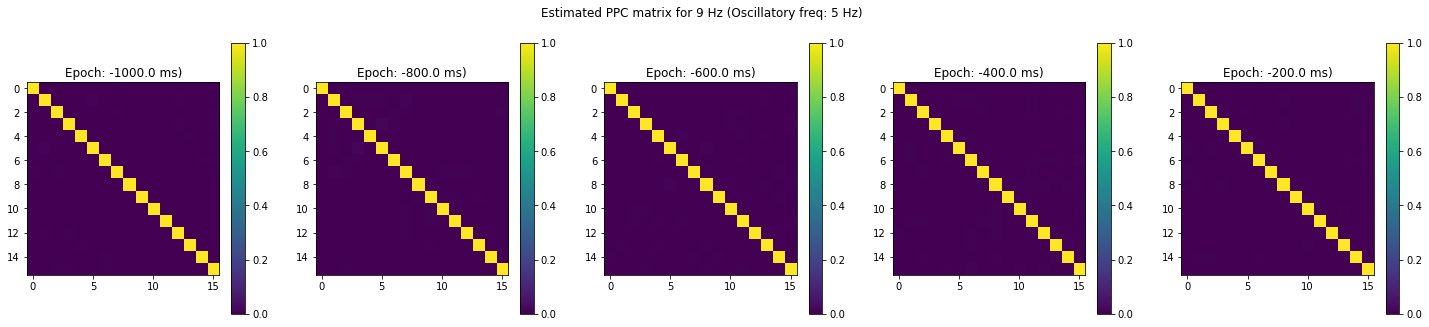

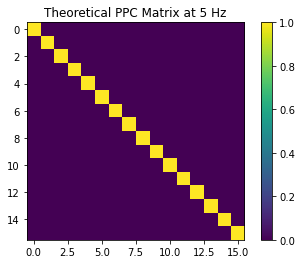

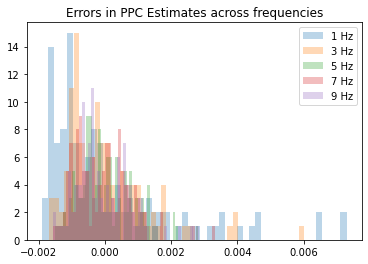

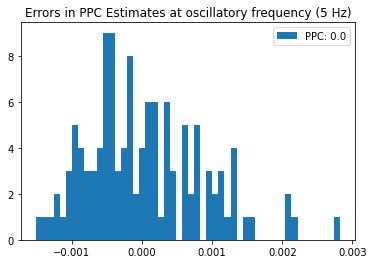

In [64]:
# only noise in connectivity pattern

# noise injects uniform random phase noise into signal
# phase distribution of sums of random variables (e.g., complex normal distributed variables) quickly gets complicated. 
# See Luo et al. (2020) "Analysis on Functions and Characteristics of the Rician Phase Distribution"

# rather than try to derive the phase distribution for our additive noise model, I add a reasonable amount of noise and confirm that we can still estimate the PPC

# simulate EEG with desired connectivity pattern


n_channels = 16
theoretical_noise_ppc = np.eye(n_channels)
theta_frequency = 5

_ = simulate_subject_eeg_ppc(n_events=500,
                            n_channels=n_channels,
                            wavelet_amplitude=0,
                            pinknoise_amplitude=1,
                            pinknoise_exponent=2,
                            theta_frequency=5,
                            morlet_reps=5,
                            connectivity_covar=connectivity_covar,
                            sample_rate=1000,  # Hz
                            start_time_ms=-1000,
                            duration_ms=1000,
                            buffer_ms=1000,
                             phase_estimate_frequencies=theta_frequencies,
                            verbose=True,
                            ppc_matrix=theoretical_noise_ppc)


Observed total power: 0.9608 +/- 0.1217 (Mean +/- STD) (0.005442 SEM) across 500 simulations
Expected signal power: 1
Expected pink noise power: 0.25
Average normalized power across channels and trials: 1.252888982185108


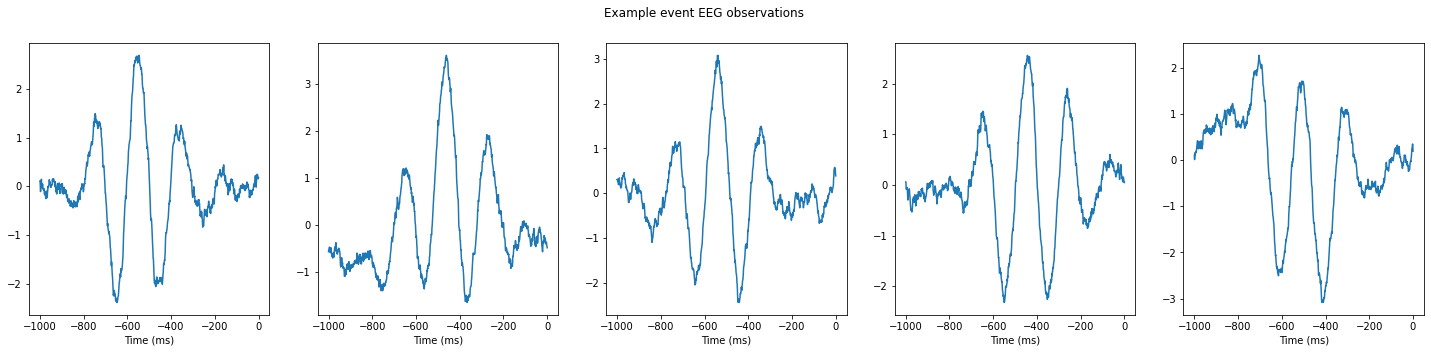

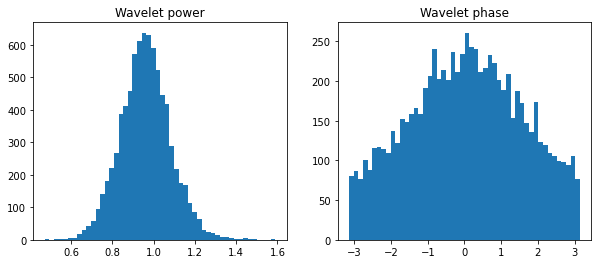

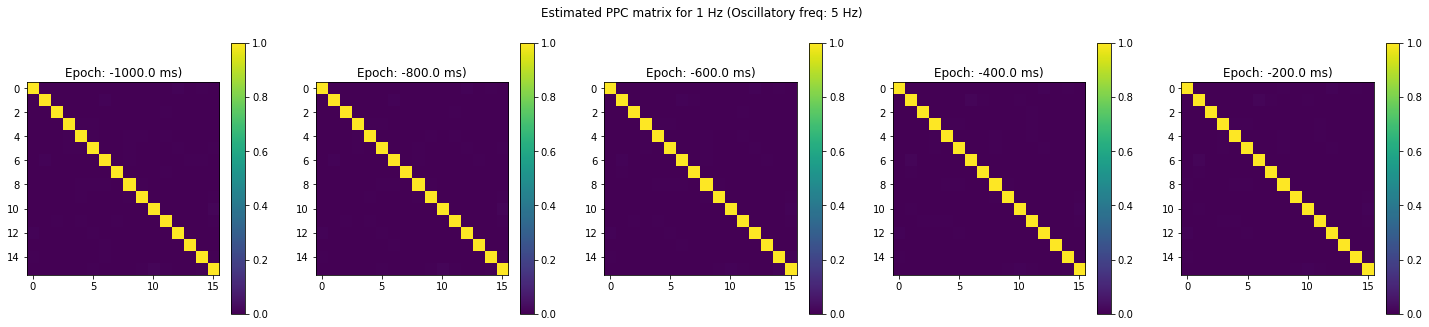

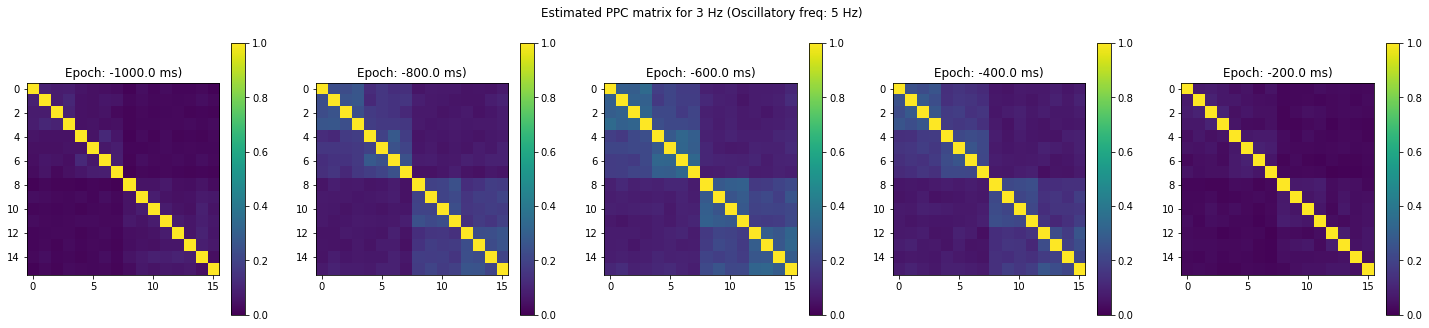

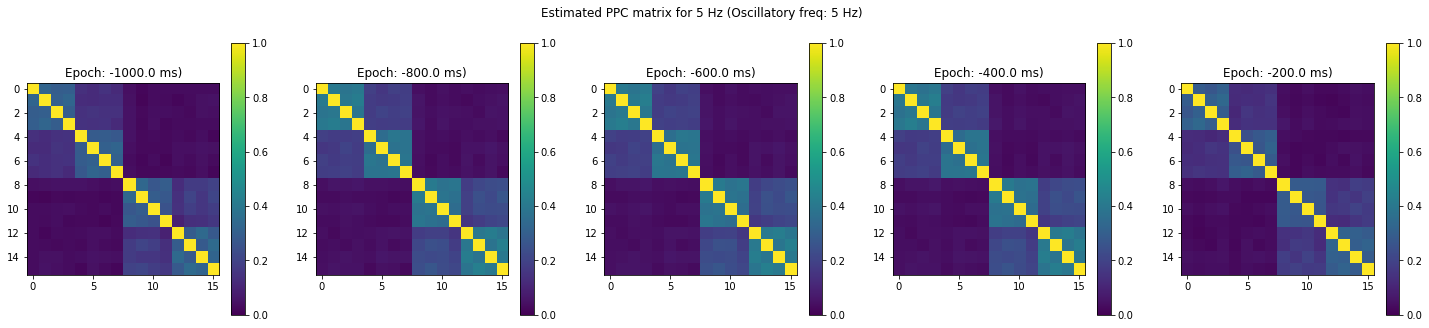

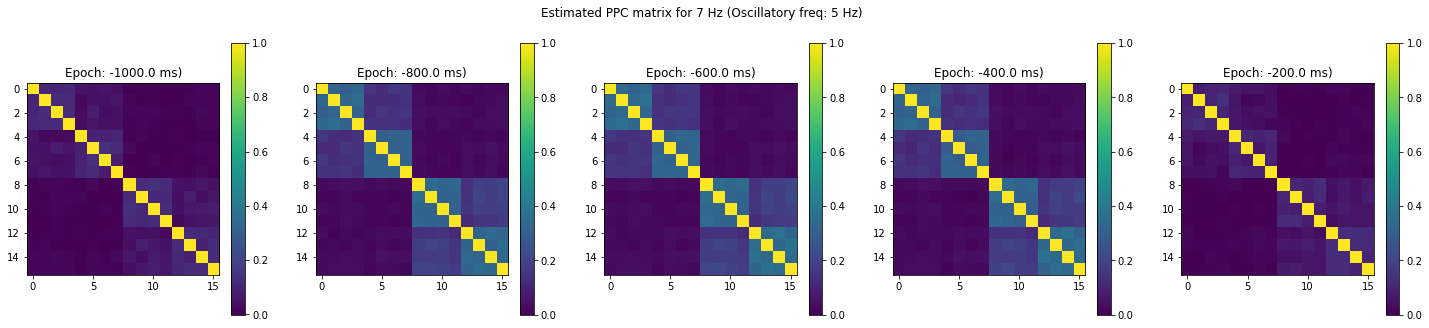

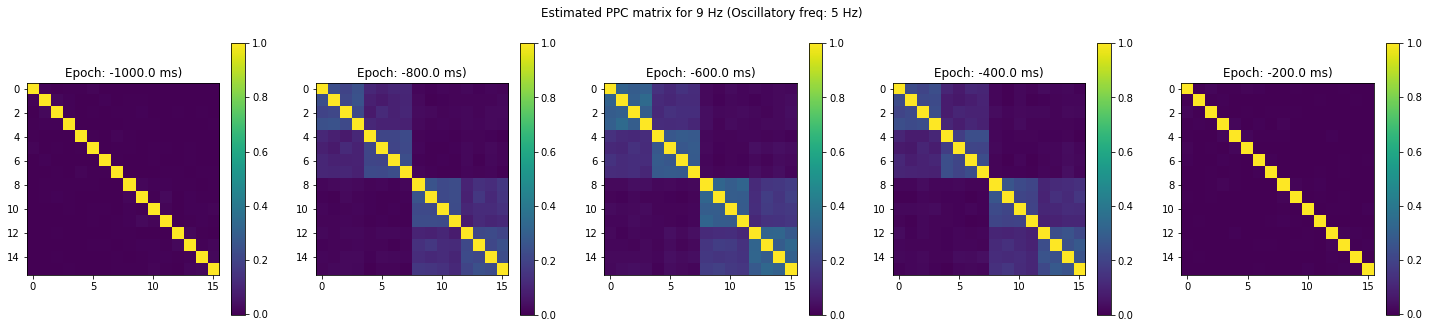

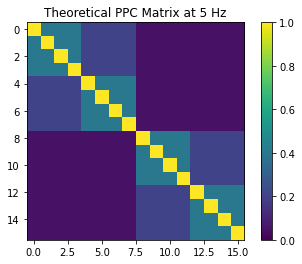

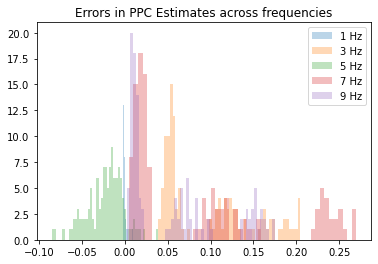

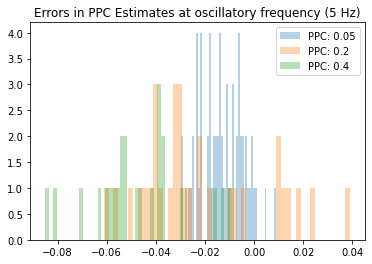

In [65]:
# reduced noise in connectivity pattern

# noise injects uniform random phase noise into signal
# phase distribution of sums of random variables (e.g., complex normal distributed variables) quickly gets complicated. 
# See Luo et al. (2020) "Analysis on Functions and Characteristics of the Rician Phase Distribution"

# rather than try to derive the phase distribution for our additive noise model, I add a reasonable amount of noise and confirm that we can still estimate the PPC

# simulate EEG with desired connectivity pattern


theta_frequency = 5
n_channels = 16

_ = simulate_subject_eeg_ppc(n_events=500,
                            n_channels=n_channels,
                            wavelet_amplitude=1,
                            pinknoise_amplitude=0.5,
                            pinknoise_exponent=2,
                            theta_frequency=5,
                            morlet_reps=5,
                            connectivity_covar=connectivity_covar,
                            sample_rate=1000,  # Hz
                            start_time_ms=-1000,
                            duration_ms=1000,
                            buffer_ms=1000,
                             phase_estimate_frequencies=theta_frequencies,
                            verbose=True,
                            ppc_matrix=ppc_matrix)


In [66]:
# simulate PPC differences

def simulate_subject_eeg_ppc_differences(n_events0=100,
                                         n_events1=100,
                                         n_channels=5,
                                         wavelet_amplitude0=1,
                                         wavelet_amplitude1=1,
                                         pinknoise_amplitude0=1,
                                         pinknoise_amplitude1=1,
                                         pinknoise_exponent0=1,
                                         pinknoise_exponent1=1,
                                         theta_frequency=5,
                                         connectivity_covar0=None,
                                         connectivity_covar1=None,
                                         ppc_matrix0=None,
                                         ppc_matrix1=None,
                                         random_state=None,
                                         verbose=False,
                                         **args,
                                         # morlet_reps=5,
                                         # sample_rate=1000,  # Hz
                                         # start_time_ms=-1000,
                                         # duration_ms=1000,
                                         # buffer_ms=1000,
                                         # phase_estimate_frequencies=[theta_frequency],
                                         # epoch_width_ms=200,
                                         # verbose=False,
                                        ):
    
    signal0, estimated_ppcs0 = simulate_subject_eeg_ppc(n_events=n_events0,
                                                        n_channels=n_channels,
                                                        wavelet_amplitude=wavelet_amplitude0,
                                                        pinknoise_amplitude=pinknoise_amplitude0,
                                                        pinknoise_exponent=pinknoise_exponent0,
                                                        theta_frequency=theta_frequency,
                                                        connectivity_covar=connectivity_covar0,
                                                        ppc_matrix=ppc_matrix0,
                                                        # verbose=True,
                                                        **args
                                                       )
    signal1, estimated_ppcs1 = simulate_subject_eeg_ppc(n_events=n_events1,
                                                        n_channels=n_channels,
                                                        wavelet_amplitude=wavelet_amplitude1,
                                                        pinknoise_amplitude=pinknoise_amplitude1,
                                                        pinknoise_exponent=pinknoise_exponent1,
                                                        theta_frequency=theta_frequency,
                                                        connectivity_covar=connectivity_covar1,
                                                        ppc_matrix=ppc_matrix1,
                                                        # verbose=True,
                                                        **args
                                                       )
                                                        # morlet_reps=morlet_reps,
                                                        # sample_rate=sample_rate,  # Hz
                                                        # start_time_ms=start_time_ms,
                                                        # duration_ms=1000,
                                                        # buffer_ms=1000,
                                                        #  phase_estimate_frequencies=theta_frequencies,
                                                        # verbose=True,
                                                        # ppc_matrix=ppc_matrix
    
    estimated_ppc_diffs = estimated_ppcs1 - estimated_ppcs0
    ppc_diffs = ppc_matrix1 - ppc_matrix0
    signal0 = signal0.assign_coords(outcome=("event", [0] * n_events0))
    signal1 = signal1.assign_coords(outcome=("event", [1] * n_events1))
    signal = xr.concat([signal0, signal1], 'event')
    
    if verbose:
        # plot estimated and theoretical PPC difference matrices
        for frequency, estimates_freq in estimated_ppc_diffs.groupby('frequency'):
            plt.figure(figsize=(25, 5))
            for n_epoch, (epoch, estimates_epoch) in enumerate(estimates_freq.groupby('epoch')):
                plt.subplot(1, len(estimated_ppc_diffs.epoch), n_epoch + 1)
                plt.imshow(estimates_epoch)
                plt.colorbar()
                plt.title(f'Epoch: {epoch} ms)')
            plt.suptitle(f'Estimated PPC matrix for {frequency} Hz (Oscillatory freq: {theta_frequency} Hz)')

        plt.figure()
        plt.imshow(ppc_diffs)
        plt.colorbar()
        _ = plt.title(f'Theoretical PPC Difference Matrix at {theta_frequency} Hz')

        if not is_symmetric(estimated_ppc_diffs.mean('epoch')):
            print('PPC estimates are not symmetric!')

        # plot errors in PPC estimates from theoretical values for all frequencies
        plt.figure()
        for freq, estimates_freq in estimated_ppc_diffs.groupby('frequency'):
            if freq == theta_frequency:
                freq_ppc_diffs = ppc_diffs
            else:
                freq_ppc_diffs = np.zeros_like(ppc_diffs)
            ppc_errors = upper_tri_values((estimates_freq.mean('epoch') - freq_ppc_diffs).values,
                                           include_diagonal=False)
            plt.hist(ppc_errors, bins=50, label=f'{freq} Hz', alpha=0.3)
        plt.title('Errors in PPC Difference Estimates across frequencies')
        plt.legend()
        
        if theta_frequency in estimated_ppc_diffs.frequency:
            # just for oscillatory frequency
            plt.figure()
            oscillatory_estimated_ppc_diffs = estimated_ppc_diffs.sel(frequency=theta_frequency)
            ppc_errors = upper_tri_values((oscillatory_estimated_ppc_diffs.mean('epoch') - ppc_diffs).values,
                                           include_diagonal=False)
            diff_values = upper_tri_values(ppc_diffs, include_diagonal=False)
            unique_diffs = np.unique(diff_values)
            for diff_val in unique_diffs:
                mask = np.where(diff_values == diff_val)
                diff_val_errors = ppc_errors[mask]
                plt.hist(diff_val_errors, bins=50, label=f'Diff: {diff_val}', alpha=1/len(unique_diffs))
            plt.title(f'Errors in PPC Difference Estimates at oscillatory frequency ({theta_frequency} Hz)')
            plt.legend()
        
    return signal, estimated_ppc_diffs



Mean PPC: 0.07200000000000001
Mean PPC: 0.16000000000000003


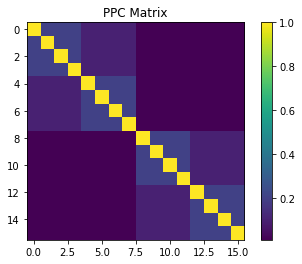

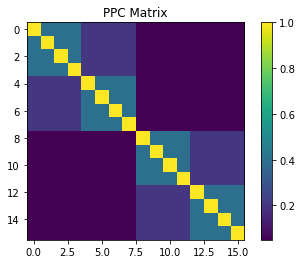

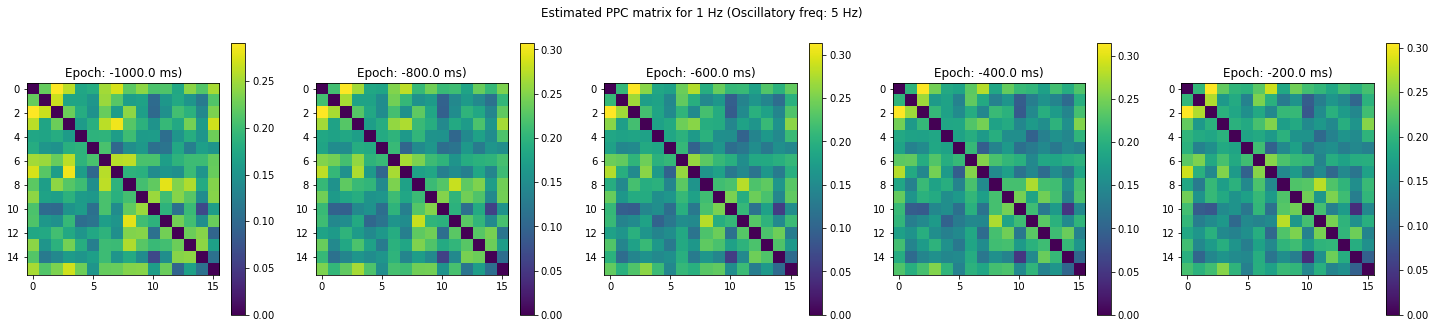

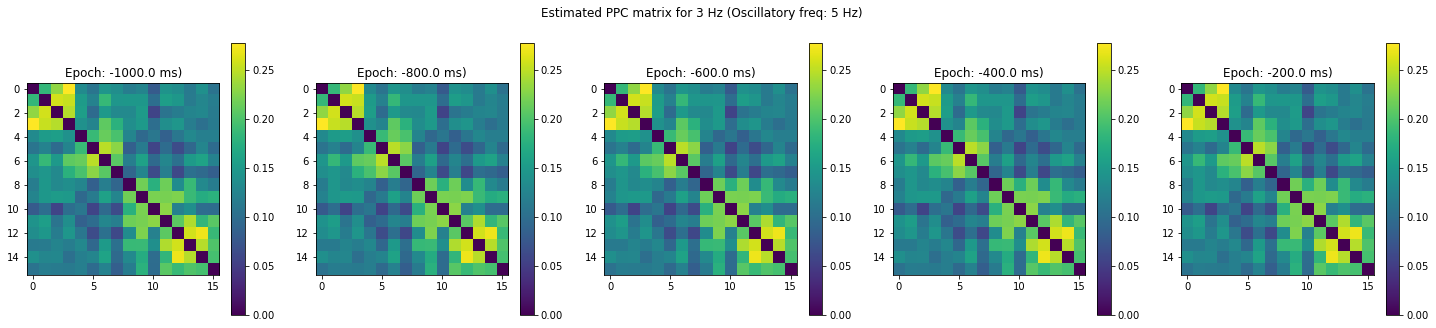

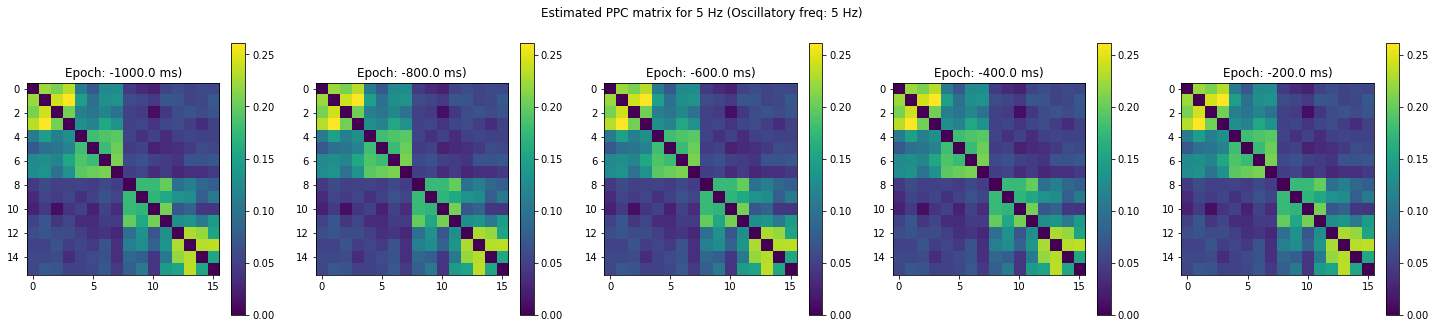

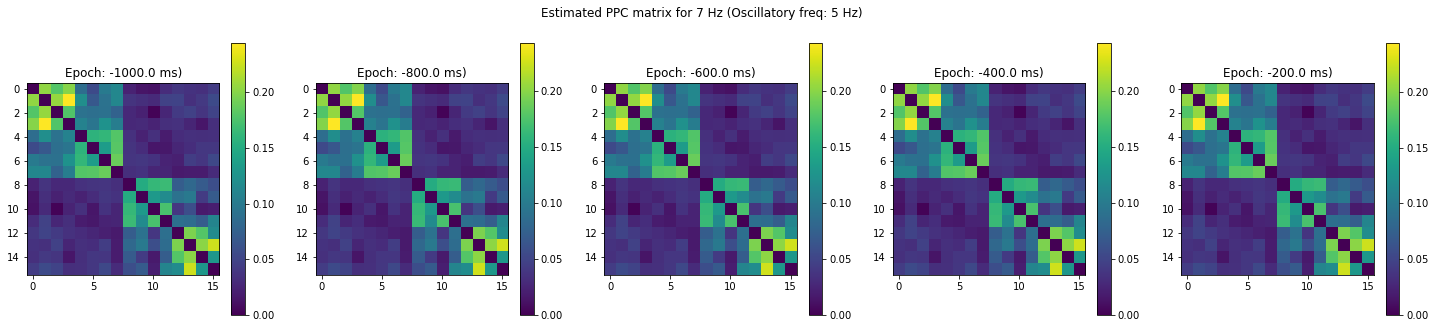

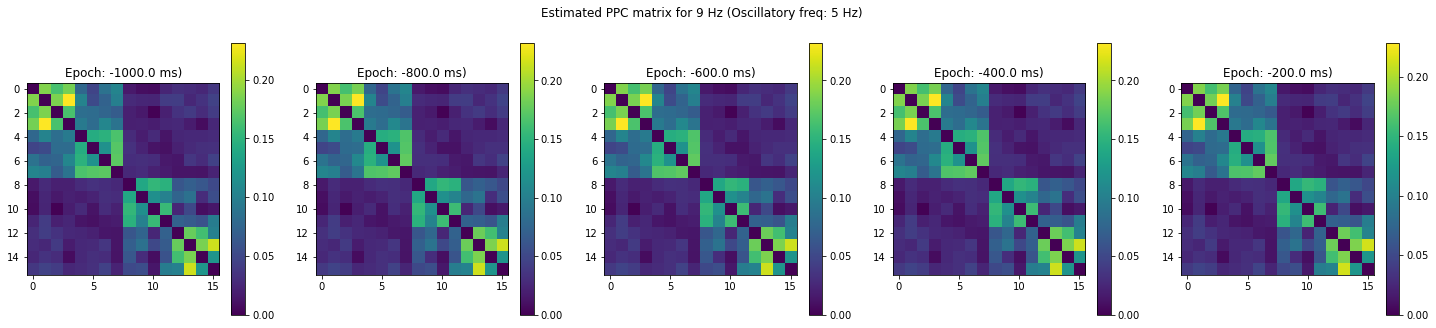

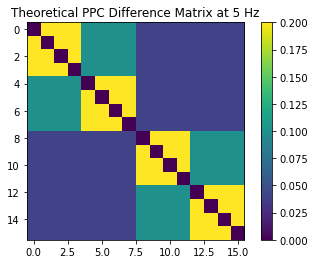

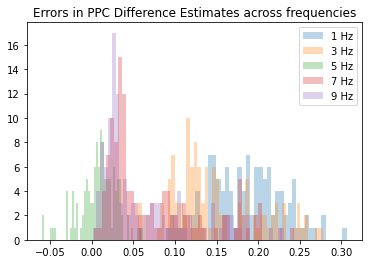

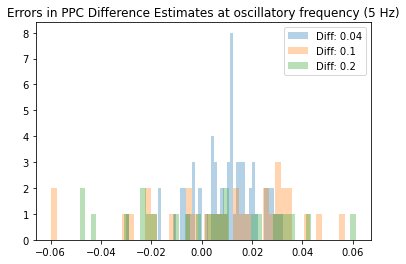

In [67]:
n_channels = 16
n_regions = 4
n_region_groups = 2

ppc_matrix0 = get_block_diagonal_ppc_matrix(n_channels=n_channels,
                                           n_regions=n_regions,
                                           n_region_groups=n_region_groups,
                                           global_ppc=0.01,
                                           within_group_ppc=0.1,
                                           within_region_ppc=0.2,
                                           verbose=True)
connectivity_covar0 = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix0)

ppc_matrix1 = get_block_diagonal_ppc_matrix(n_channels=n_channels,
                                           n_regions=n_regions,
                                           n_region_groups=n_region_groups,
                                           global_ppc=0.05,
                                           within_group_ppc=0.2,
                                           within_region_ppc=0.4,
                                           verbose=True)
connectivity_covar1 = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix1)


# simulate PPC differences with no noise
signal, estimated_ppc_diffs = simulate_subject_eeg_ppc_differences(n_events0=500,
                                                                    n_events1=500,
                                                                    n_channels=n_channels,
                                                                    wavelet_amplitude0=1,
                                                                    wavelet_amplitude1=1,
                                                                    pinknoise_amplitude0=0,
                                                                    pinknoise_amplitude1=0,
                                                                    pinknoise_exponent0=1,
                                                                    pinknoise_exponent1=1,
                                                                    theta_frequency=5,
                                                                    connectivity_covar0=connectivity_covar0,
                                                                    connectivity_covar1=connectivity_covar1,
                                                                    ppc_matrix0=ppc_matrix0,
                                                                    ppc_matrix1=ppc_matrix1,
                                                                    verbose=True,
                                                                    phase_estimate_frequencies=theta_frequencies
                                                                   )


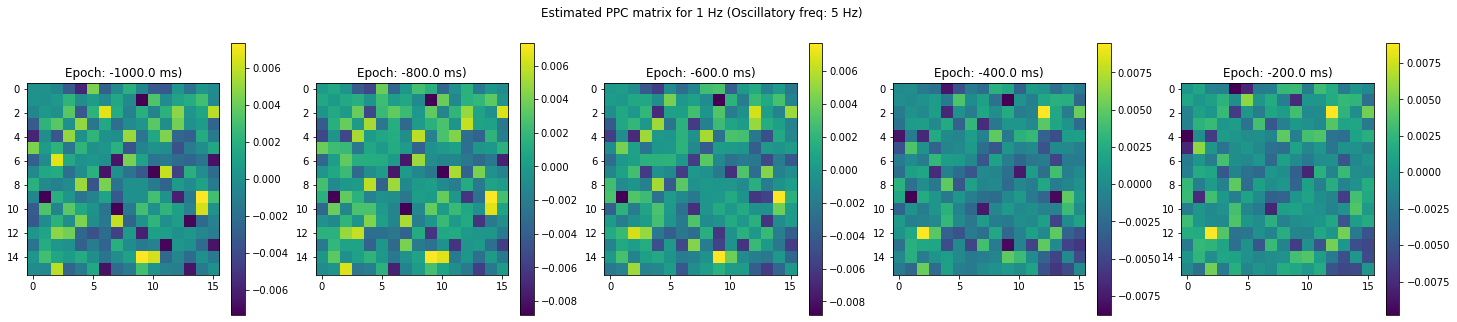

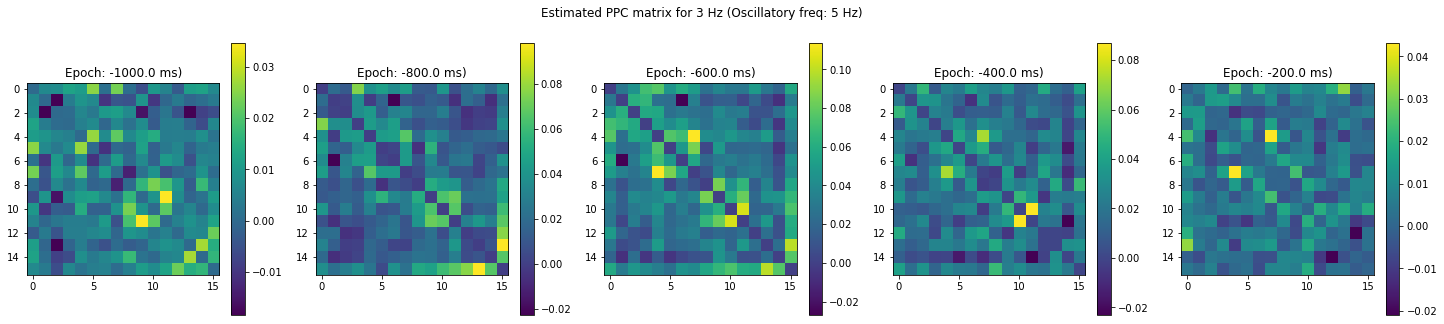

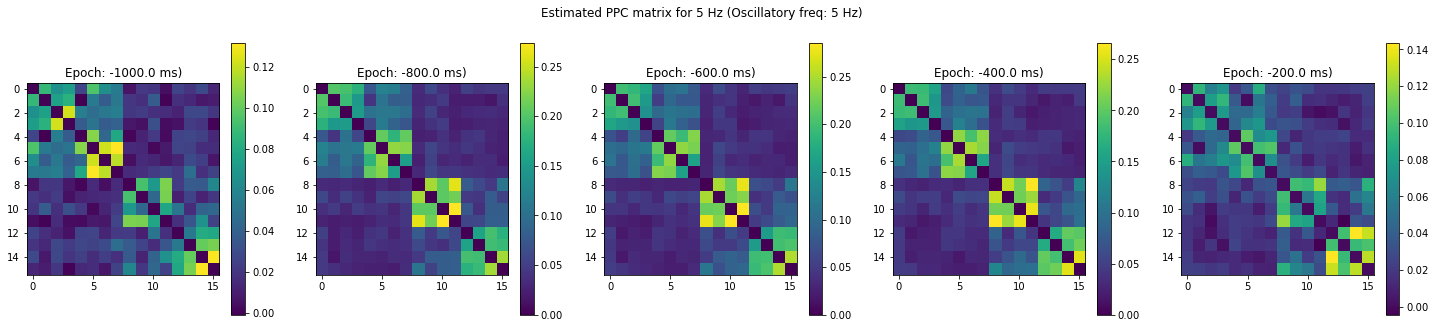

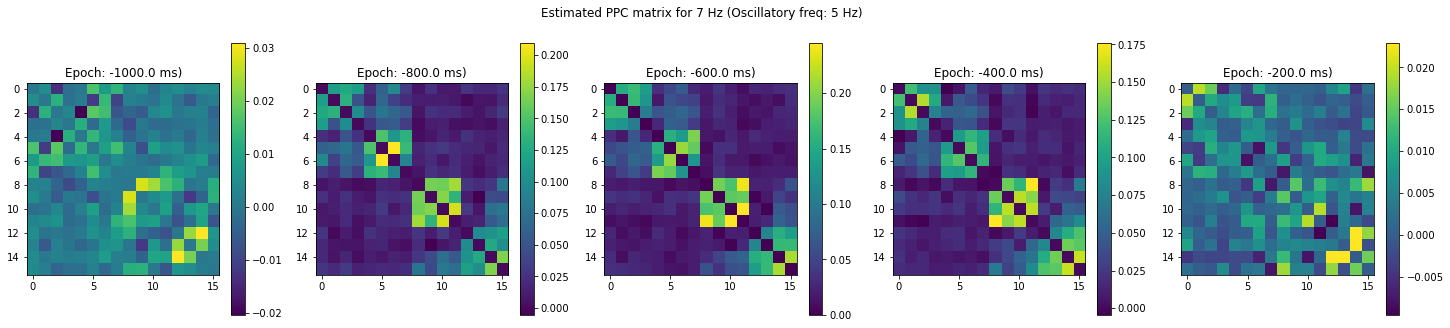

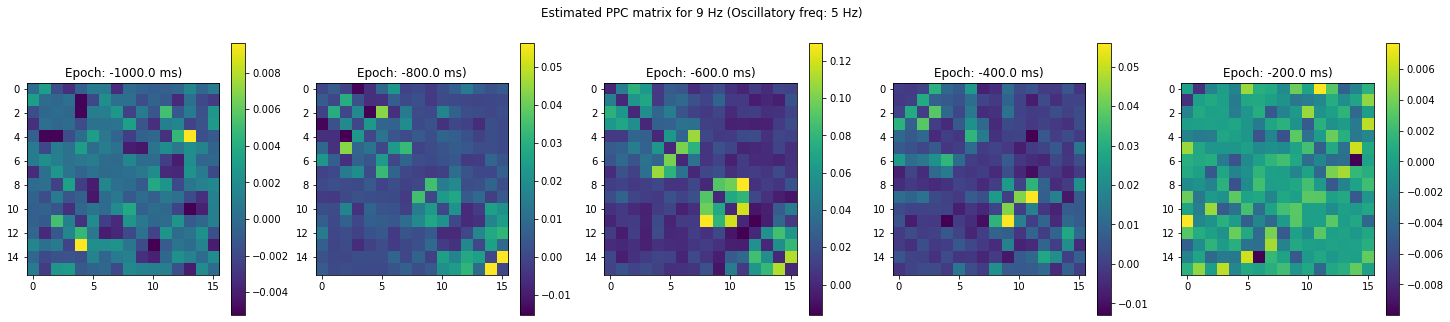

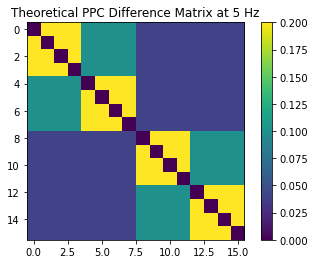

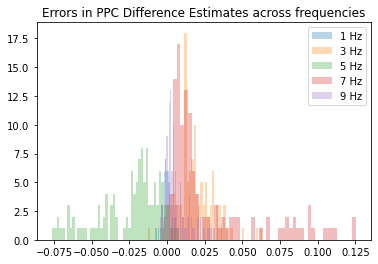

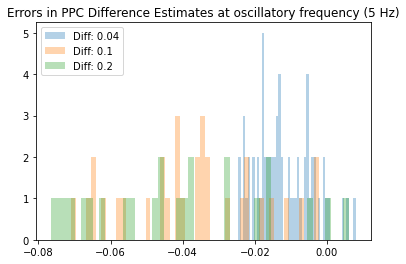

In [68]:
# add in noise
signal, estimated_ppc_diffs = simulate_subject_eeg_ppc_differences(n_events0=500,
                                                                    n_events1=500,
                                                                    n_channels=n_channels,
                                                                    wavelet_amplitude0=1,
                                                                    wavelet_amplitude1=1,
                                                                    pinknoise_amplitude0=1,
                                                                    pinknoise_amplitude1=1,
                                                                    pinknoise_exponent0=1,
                                                                    pinknoise_exponent1=1,
                                                                    theta_frequency=5,
                                                                    connectivity_covar0=connectivity_covar0,
                                                                    connectivity_covar1=connectivity_covar1,
                                                                    ppc_matrix0=ppc_matrix0,
                                                                    ppc_matrix1=ppc_matrix1,
                                                                    verbose=True,
                                                                    phase_estimate_frequencies=theta_frequencies
                                                                   )


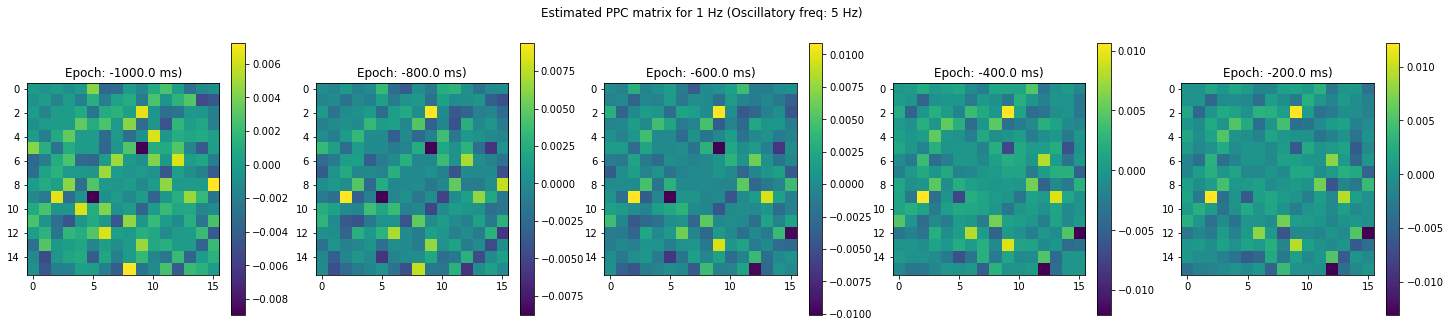

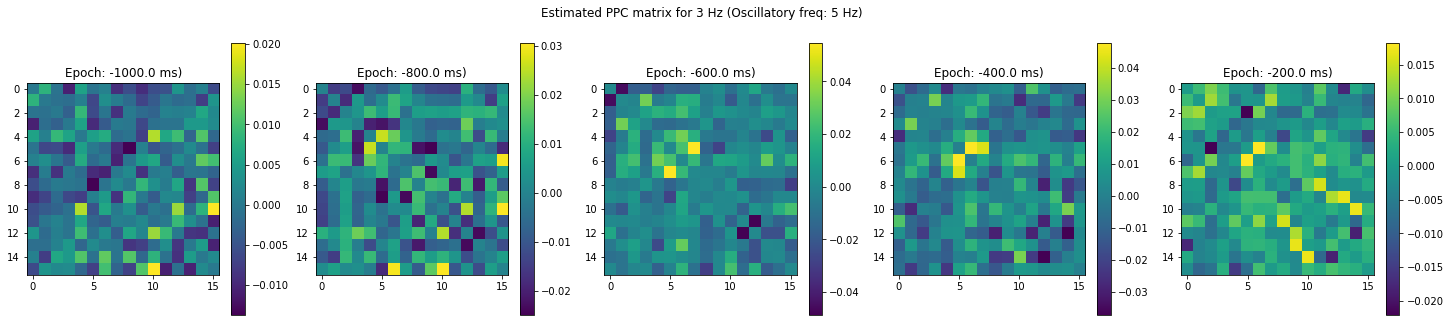

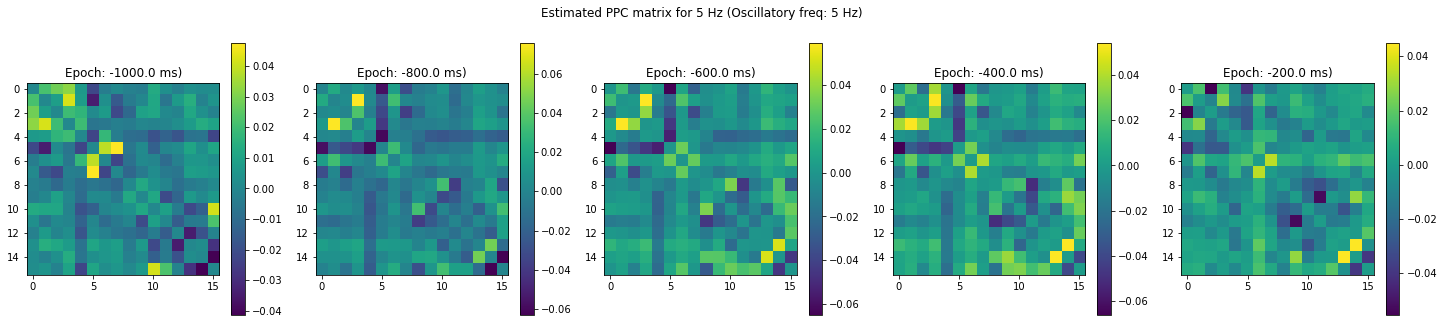

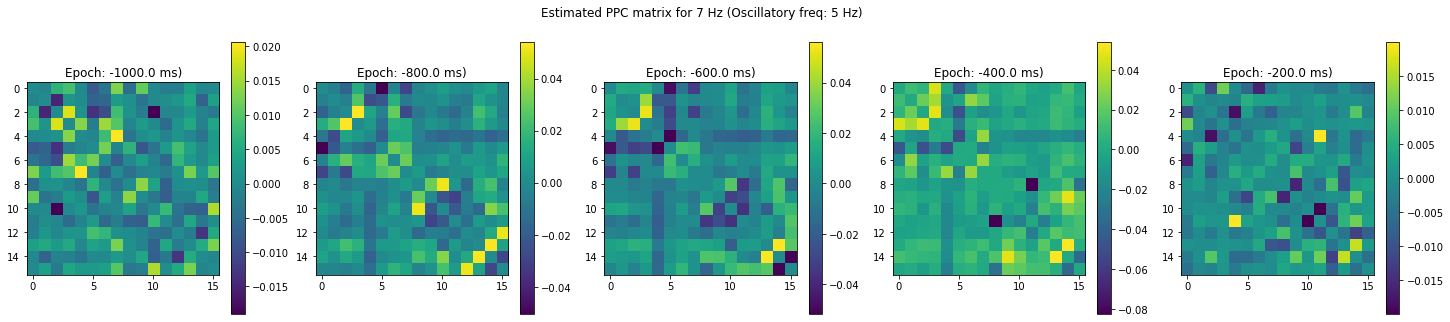

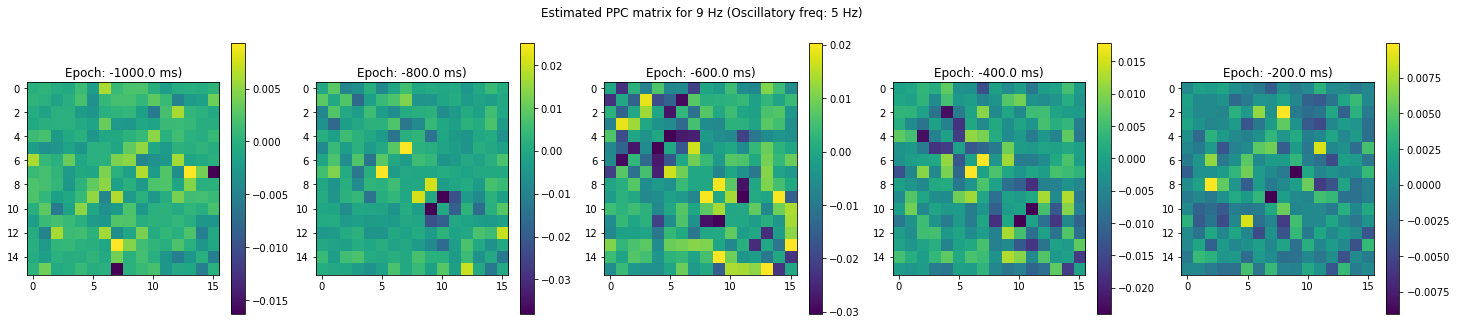

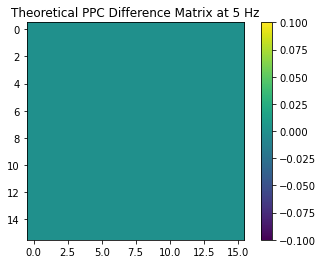

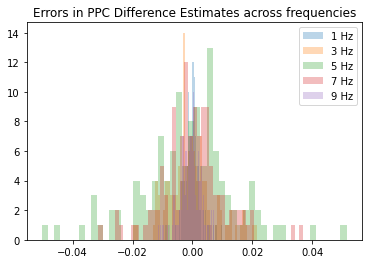

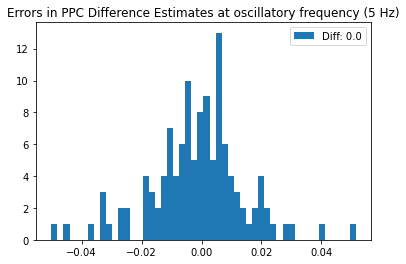

In [69]:
# simulate PPC differences with same non-null connectivity for both event outcomes

signal, estimated_ppc_diffs = simulate_subject_eeg_ppc_differences(n_events0=500,
                                                                    n_events1=500,
                                                                    n_channels=n_channels,
                                                                    wavelet_amplitude0=1,
                                                                    wavelet_amplitude1=1,
                                                                    pinknoise_amplitude0=1,
                                                                    pinknoise_amplitude1=1,
                                                                    pinknoise_exponent0=1,
                                                                    pinknoise_exponent1=1,
                                                                    theta_frequency=5,
                                                                    connectivity_covar0=connectivity_covar0,
                                                                    connectivity_covar1=connectivity_covar0,
                                                                    ppc_matrix0=ppc_matrix0,
                                                                    ppc_matrix1=ppc_matrix0,
                                                                    verbose=True,
                                                                    phase_estimate_frequencies=theta_frequencies
                                                                   )

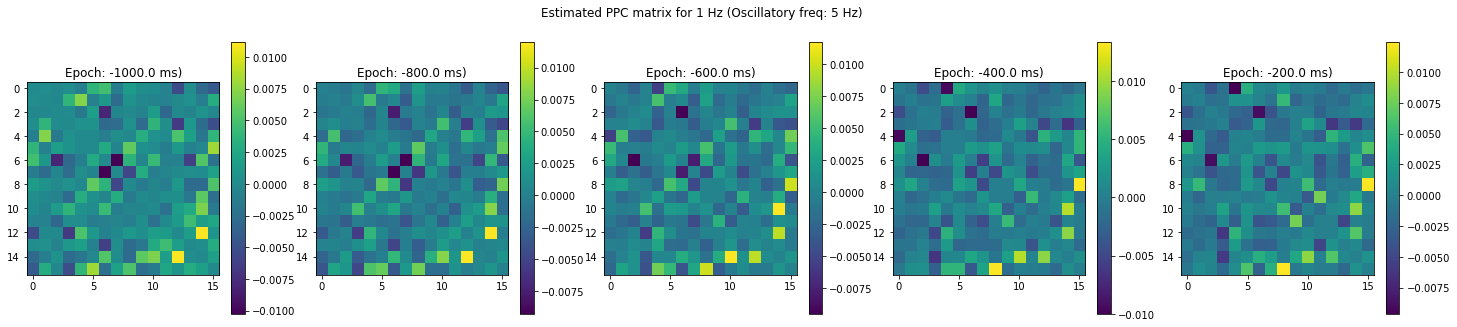

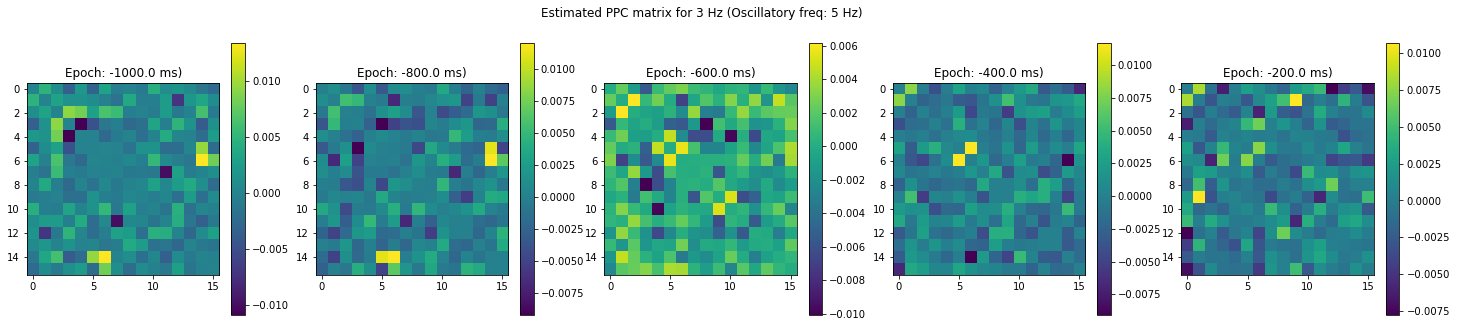

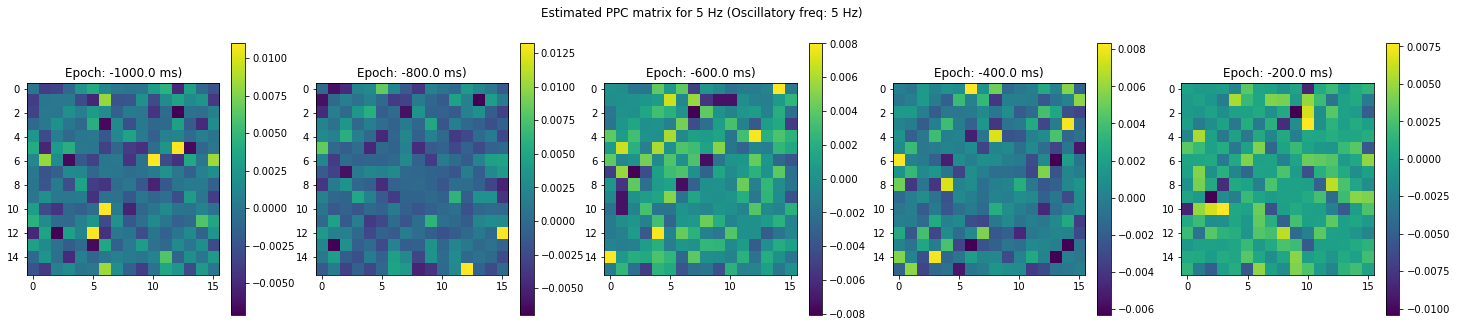

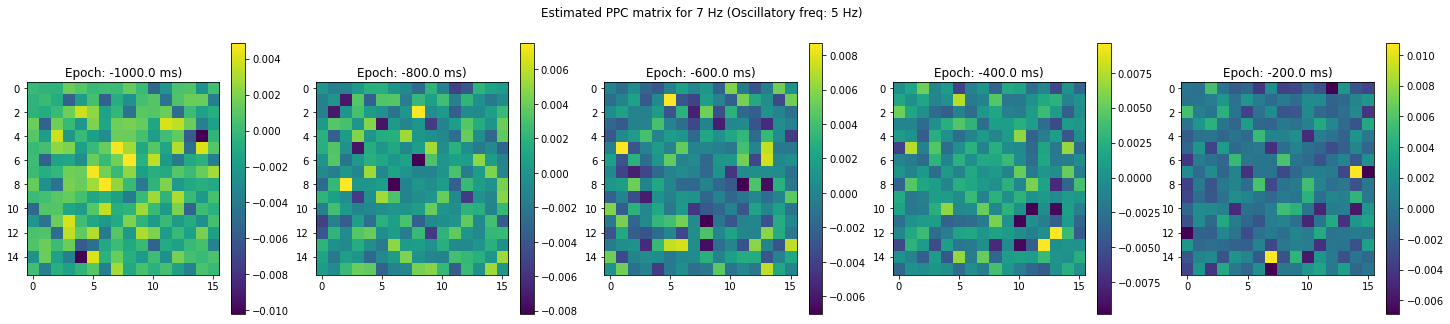

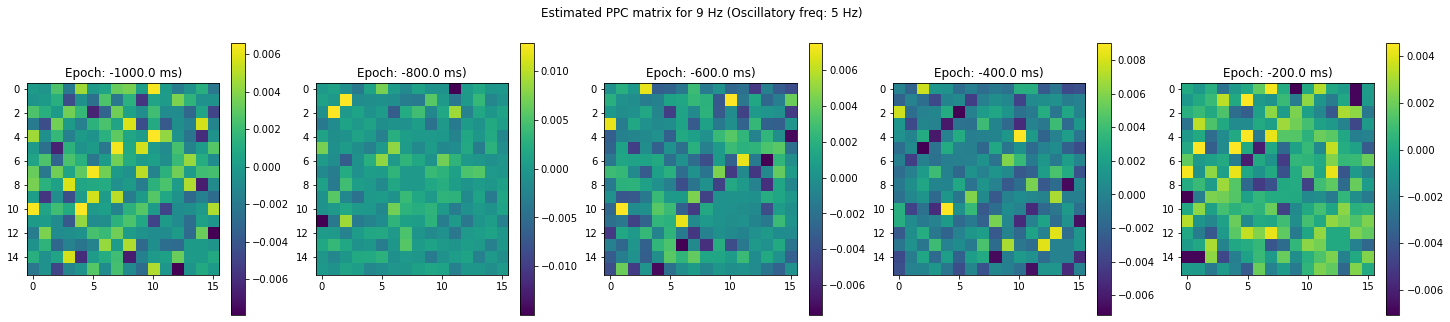

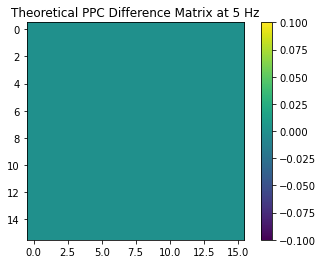

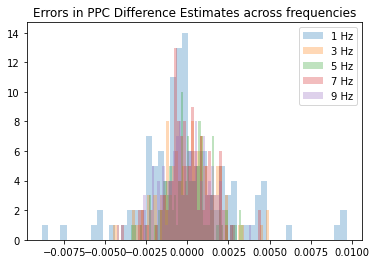

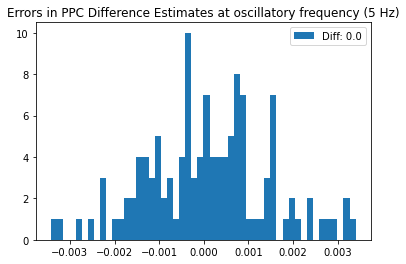

In [70]:
# simulate PPC differences with same null connectivity for both event outcomes

signal, estimated_ppc_diffs = simulate_subject_eeg_ppc_differences(n_events0=500,
                                                                    n_events1=500,
                                                                    n_channels=n_channels,
                                                                    wavelet_amplitude0=0,
                                                                    wavelet_amplitude1=0,
                                                                    pinknoise_amplitude0=1,
                                                                    pinknoise_amplitude1=1,
                                                                    pinknoise_exponent0=1,
                                                                    pinknoise_exponent1=1,
                                                                    theta_frequency=5,
                                                                    connectivity_covar0=np.eye(n_channels),
                                                                    connectivity_covar1=np.eye(n_channels),
                                                                    ppc_matrix0=np.eye(n_channels),
                                                                    ppc_matrix1=np.eye(n_channels),
                                                                    verbose=True,
                                                                    phase_estimate_frequencies=theta_frequencies
                                                                   )

In [71]:
# average matched recalls per subject
n_session_per_subject = 3
n_items = 300
mean_recall_rate = 0.3
match_rate = 0.34
average_matches_per_subject = n_session_per_subject * n_items * mean_recall_rate * match_rate
average_matches_per_subject


91.80000000000001

In [27]:
# simulate PPC difference estimates from a sample of subjects

import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm
import cmldask
from cmldask import CMLDask
from cluster import wait


def cluster_run_ppc_differences(random_state, verbose=False, smokescreen=False):
    np.random.seed(random_state)
    if smokescreen:
        n_events = 5
        n_channels = 20
        n_regions = 10
        n_region_groups = 2
    else:
        n_events = 100
        n_channels = 160
        n_regions = 80
        n_region_groups = 8

    ppc_matrix0 = get_block_diagonal_ppc_matrix(n_channels=n_channels,
                                               n_regions=n_regions,
                                               n_region_groups=n_region_groups,
                                               global_ppc=0.01,
                                               within_group_ppc=0.1,
                                               within_region_ppc=0.2,
                                               verbose=verbose,
                                               )
    connectivity_covar0 = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix0)

    ppc_matrix1 = get_block_diagonal_ppc_matrix(n_channels=n_channels,
                                               n_regions=n_regions,
                                               n_region_groups=n_region_groups,
                                               global_ppc=0.05,
                                               within_group_ppc=0.2,
                                               within_region_ppc=0.4,
                                               verbose=verbose,
                                               )
    connectivity_covar1 = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix1)
    
    _, estimated_ppc_diffs = simulate_subject_eeg_ppc_differences(n_events0=n_events,
                                                                       n_events1=n_events,
                                                                       n_channels=n_channels,
                                                                       wavelet_amplitude0=1,
                                                                       wavelet_amplitude1=1,
                                                                       pinknoise_amplitude0=1,
                                                                       pinknoise_amplitude1=1,
                                                                       pinknoise_exponent0=1,
                                                                       pinknoise_exponent1=1,
                                                                       theta_frequency=5,
                                                                       connectivity_covar0=connectivity_covar0,
                                                                       connectivity_covar1=connectivity_covar1,
                                                                       ppc_matrix0=ppc_matrix0,
                                                                       ppc_matrix1=ppc_matrix1,
                                                                       verbose=verbose,
                                                                       phase_estimate_frequencies=theta_frequencies
                                                                      )
    return estimated_ppc_diffs

smokescreen = True
tag = 'base'
n_subjects = 400 if not smokescreen else 2
random_state_offset = 42


# for testing
# cluster_run_ppc_differences(2, verbose=True, smokescreen=True)

client = new_dask_client_slurm('sub_ppc', '10G', 400, walltime=10000)
futures = client.map(cluster_run_ppc_differences,
                     list(np.arange(n_subjects) + random_state_offset),
                     [False] * n_subjects,
                     [smokescreen] * n_subjects,
                    )
wait(futures, client, check_delay=30)
results = client.gather(CMLDask.filter_futures(futures))

import pickle
if not smokescreen:
    with open(f'results/subject_level_ppc_simulation_{tag}.pkl', 'wb') as f:
        pickle.dump(results, f)

client.shutdown()


Simulations finished after 30.0 s: 2 / 2 (0.0666 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [28]:
results = xr.concat(results, dim='subject')

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Integrate EEG Simulation with cmlreaders

In [157]:
from cmlreaders import CMLReader


reader = CMLReader(subject='R1001P', experiment='FR1', session=0)
dfrow = pd.Series({'sub': 'R1001P', 'exp': 'FR1', 'sess': 0, 'loc': 0, 'mon': 0})
events = reader.load('events')
scheme = reader.load('pairs')

original_eeg = reader.load_eeg(events=events, rel_start=-1000, rel_stop=1000, scheme=scheme)


In [158]:
import helper
from helper import get_pairs, get_localization, regionalize_electrodes, exclude_regionalizations, find_overlapping_pairs
from misc import get_username_from_working_directory
USERNAME = get_username_from_working_directory(index=2)
root_dir = f'/scratch/{USERNAME}/retrieval_connectivity2'

helper.root_dir = root_dir

pairs = get_pairs(dfrow)

localization = get_localization(dfrow)
regionalizations = regionalize_electrodes(pairs, localization)
regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
print(len(pairs))
print(len(regionalizations))

72
72


In [23]:
assert (pd.Series(regionalizations).str.startswith('L ') | pd.Series(regionalizations).str.startswith('R ')).all()
region_groups = ['Left' if left else 'Right' for left in pd.Series(regionalizations).str.startswith('L ')]
# regions = [reg[2:] for reg in regionalizations]
# assert not (pd.Series(regions).str.startswith('L ') | pd.Series(regions).str.startswith('R ')).any()

# region_dataframe_path='regions_lobes_df.csv',
# region_df = pd.read_csv(region_dataframe_path)


Mean PPC: 0.13262910798122066


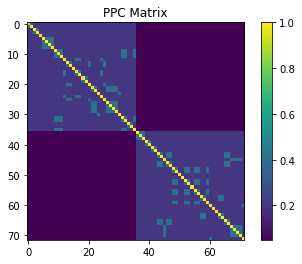

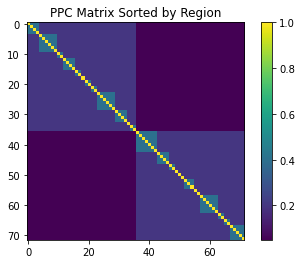

In [24]:
from simulate_eeg import get_block_diagonal_ppc_matrix, ppc_matrix_to_wrapped_normal_covariance

ppc_matrix = get_block_diagonal_ppc_matrix(n_channels=None,
                                           n_regions=None,
                                           n_region_groups=None,
                                           regions=list(regionalizations),
                                           region_groups=list(region_groups),
                                           global_ppc=0.05,
                                           within_group_ppc=0.2,
                                           within_region_ppc=0.4,
                                           verbose=True)
connectivity_covar = ppc_matrix_to_wrapped_normal_covariance(ppc_matrix)


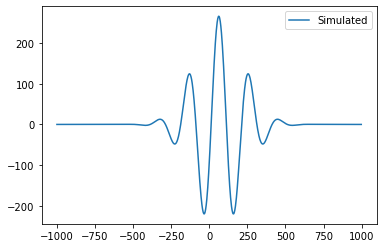

In [196]:
from misc import get_username_from_working_directory
import os

USERNAME = get_username_from_working_directory(index=2)
root_dir = f'/scratch/{USERNAME}/retrieval_connectivity2'

# specify hypothesis for end-to-end testing of this analysis pipeline with simulated EEG data
# simulation_tag = 'null_connectivity'
# simulation_tag = 'noisy_oscillation'
simulation_tag = 'strong_oscillation_only'
is_simulation = simulation_tag not in ['standard', '', None]
from simulate_eeg import AVAILABLE_SIMULATIONS

if is_simulation:
    assert simulation_tag in AVAILABLE_SIMULATIONS
    root_dir = os.path.join(root_dir, 'simulation_tests', simulation_tag)

from simulate_eeg import AVAILABLE_SIMULATIONS, simulation_parameters
import helper
from helper import replace_w_simulated_EEG
helper.root_dir = root_dir

ptsa_eeg = original_eeg.to_ptsa()
condition_mask = np.array(ptsa_eeg.recalled == 1)

eeg = replace_w_simulated_EEG(ptsa_eeg,
                              dfrow,
                              condition_mask=condition_mask,
                              scheme=pairs,
                              simulation_tag=simulation_tag,
                              # random_state=4,
                             )
plt.figure()
plt.plot(eeg.time, eeg.data[0, 0], label='Simulated')
# plt.plot(original_eeg.time, original_eeg.data[0, 0], label='Original')
_ = plt.legend()


In [195]:
# condition_mask = np.array(ptsa_eeg.recalled == 1)
# ptsa_eeg[condition_mask]

In [187]:
from simulate_eeg import AVAILABLE_SIMULATIONS, simulation_parameters
simulation_parameters[simulation_tag]


{'wavelet_amplitude': 100,
 'phase_covariance_function': 'within_region_group',
 'global_ppc0': 0.01,
 'within_group_ppc0': 0.1,
 'within_region_ppc0': 0.3,
 'global_ppc1': 0.05,
 'within_group_ppc1': 0.2,
 'within_region_ppc1': 0.5,
 'oscillation_frequency': 5,
 'morlet_reps': 5,
 'pinknoise_amplitude': 0,
 'pinknoise_exponent': 1}

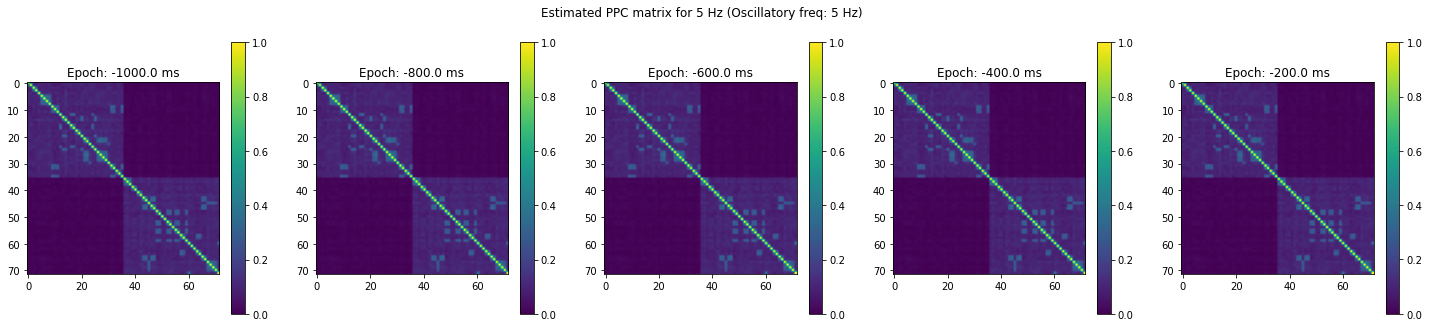

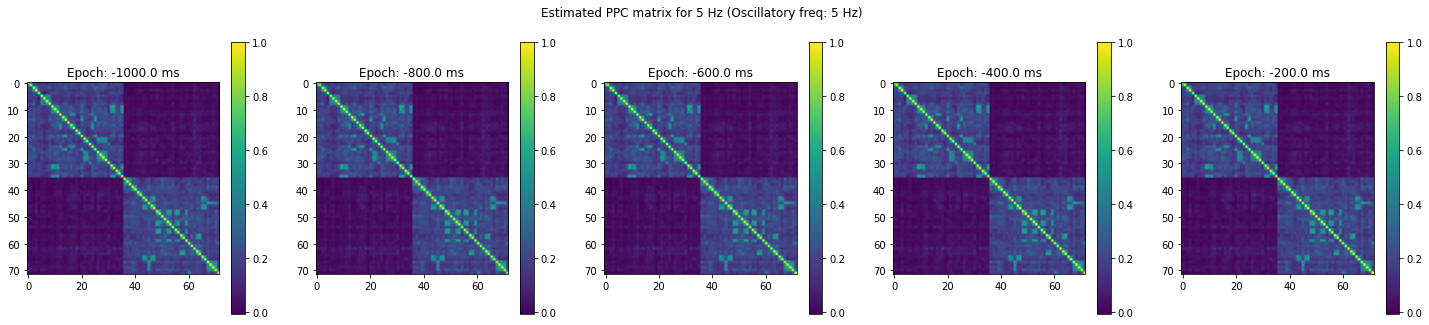

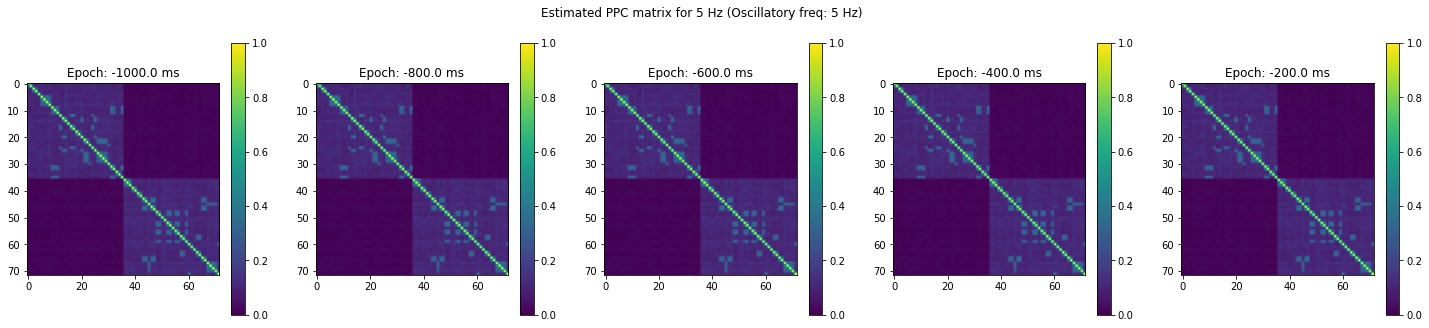

In [199]:
def plot_ppc(signal, phase_estimate_frequencies=[5], epoch_width_ms=200, theta_frequency=5):
    from eeg_processing import get_phase, timebin_phase_timeseries
    phases = get_phase(signal, freqs=phase_estimate_frequencies, width=5)
    estimated_ppcs = compute_ppc_matrix_nonoverlapping(phases,
                                                       phases.samplerate,
                                                       epoch_width_ms=epoch_width_ms)
    
    # plot estimated and theoretical PPC matrices
    for frequency, estimated_ppcs_freq in estimated_ppcs.groupby('frequency'):
        plt.figure(figsize=(25, 5))
        for n_epoch, (epoch, estimated_ppcs_epoch) in enumerate(estimated_ppcs_freq.groupby('epoch')):
            plt.subplot(1, len(estimated_ppcs.epoch), n_epoch + 1)
            plt.imshow(estimated_ppcs_epoch)
            plt.colorbar()
            plt.title(f'Epoch: {epoch} ms')
        plt.suptitle(f'Estimated PPC matrix for {frequency} Hz (Oscillatory freq: {theta_frequency} Hz)')

    # plt.figure()
    # plt.imshow(ppc_matrix)
    # plt.colorbar()
    # _ = plt.title(f'Theoretical PPC Matrix at {theta_frequency} Hz')

eeg0 = eeg.sel(recalled=0)
eeg1 = eeg.sel(recalled=1)

plot_ppc(eeg0.isel(time=eeg0.time < 0))
plot_ppc(eeg1.isel(time=eeg1.time < 0))
plot_ppc(eeg.isel(time=eeg.time < 0))


## TODO
Method for simulating phase-locked EEG:
1. DONE Sample phases
    - Sample from wrapped multivariate normal distribution with known channel-wise phase covariances
2. DONE Generate wavelets in the theta band with sampled phase offsets
3. Add wavelets to 1/f background noise distribution, setting the effect size / SNR
    - no easy way to estimate effect of phase noise from 1/f background distribution
    - complex normal distribution has involved phase distribution and it seems unlikely to have nice covariance properties

Approach for validating analyses from Rao et al. (2024):

1. Sample behavioral outcomes (e.g., retrieval vs. failed search period, SME) or just use observed behavior data
2. Generate EEG based on known functional connectivity
3. Simulate analyses from paper across a range of PPCs, SNRs, and sample sizes


## Miscellaneous

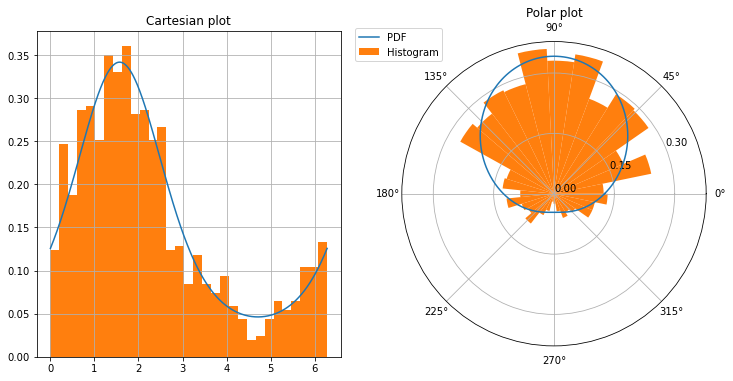

In [50]:
loc = 0.5 * np.pi  # circular mean
scale = 1

kappa = 1  # concentration
vonmises.pdf(0, loc=loc, kappa=kappa)

x = 1

# cdf_value = vonmises.cdf(x, loc=loc, kappa=kappa, scale=scale)
# ppf_value = vonmises.ppf(cdf_value, loc=loc, kappa=kappa, scale=scale)

sample_size = 1000

sample = vonmises(loc=loc, kappa=kappa, scale=scale).rvs(sample_size) % (2 * np.pi)
fig = plt.figure(figsize=(12, 6))
left = plt.subplot(121)
right = plt.subplot(122, projection='polar')
x = np.linspace(0, 2 * np.pi, 500)

vonmises_pdf = vonmises.pdf(x, loc=loc, kappa=kappa, scale=scale)
# ticks = [0, 0.15, 0.3]


number_of_bins = int(np.sqrt(sample_size))

left.plot(x, vonmises_pdf)
# left.set_yticks(ticks)
left.hist(sample, density=True, bins=number_of_bins)
left.set_title("Cartesian plot")
# left.set_xlim(-np.pi, np.pi)
left.grid(True)

right.plot(x, vonmises_pdf, label="PDF")
right.set_yticks(ticks)
right.hist(sample, density=True, bins=number_of_bins,
           label="Histogram")
right.set_title("Polar plot")
_ = right.legend(bbox_to_anchor=(0.15, 1.06))